# Downstream Analysis and Clustering

This is an optional downstream analysis of compounds. Some of the scripts are similar to those used in the main protocol, however, were copied and adjusted to the downstream analysis for clarity. Some scripts are directly reused from the protocol. 

## Imports

In [1]:

import matplotlib
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.backends.backend_pdf

import numpy as np
import pandas as pd

from guacamol.common_scoring_functions import CNS_MPO_ScoringFunction
from guacamol.utils.descriptors import mol_weight, logP, num_H_donors, tpsa

from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


# Matplotlib font changes for plotting 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


## Helpers

### Create custom cmap (for colors in plots below)

In [2]:
# Create a list of colors to transition between
color1 = "#4285f4"  # "#1a237e" 
color2 = "#0f9d58"  
color3 = "#f4b400" 
color4 = "#db4437"
colors = [color1, color2, color3]

cmap_name = 'custom_colormap'
n_colors = 256 

# Create a colormap with a smooth transition
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_colors)

## Step 1: Clustering

**Summary: Cluster the molecules and extract the best performing molecule of each cluster that will be then docked with AutoDock Vina.**

As we have a large number of molecules to cluster (3 million), we cannot use a traditional Butina clustering with RDKit. Following   https://macinchem.org/2023/03/05/options-for-clustering-large-datasets-of-molecules/ we can cluster molecules with Chemfp, which does allow clustering larger libraries. We can use 1.x developer line, which is non-commercial. Important to note is that Chemfp 1.x is **not compatibile with Python 3**, hence we have to create a separate environment that will run the code in **Python 2.7**. All steps to create environment, install combatibile RDKit (versions before 2019) and finally chemfp iis shown below.

In [3]:
# conda create -y -n DD_protocol_py27 python=2.7
# conda activate DD_protocol_py27
# conda install -c rdkit rdkit=2018.09.1
# pip install chemfp

Aleternatively, the environment can be installed from the provided *DD_protocol_py27.yml* file.

In [4]:
# !conda env create -f DD_protocol_py27.yml

### Step 1.1: Get fingerprints

Now, to create a compatibile fingerprints from smiles for the molecules we want to cluster we can do. We preserve the same fingerprint settings as for the pipeline steps - Morgan, fingerprint size 1024, radius 2 and taking chirality into account.

In [5]:
# sbatch --account={account_name} --partition={cpu_partition} --nodes=1 --ntasks=1 --cpus-per-task=10 --time=02:00:00 --wrap="rdkit2fps extracted_smiles.smi --fpSize 1024 --morgan --radius 2 --useChirality 1 > extracted_smiles.fps"

### Step 1.2: Get clusters

Adjust names of variables accordingly, this is only example.

In [6]:
# sbatch ---account={account_name} --partition={cpu_partition} --nodes=1 --ntasks=1 --cpus-per-task=15 --time=10:30:00 --wrap="python /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/scripts_3/taylor_butina.py --profile --threshold 0.78 extracted_smiles.fps -o extracted_smiles_clusters.txt"

### Step 1.3: Get the best predicted scoring molecule from each cluster

Get the best predicted scoring molecule from each cluster, this will be used in the next step (Vina docking).


#### Step 1.3.1: Get scores for all molecules that were clusters (merge cluster table with scores table)

Adjust names of variables accordingly. This is only and example.

In [7]:
# join -1 2 -2 1 -t , <(sort -k2 -t , clusters_1024.txt) <(sort -k1 -t , ../../id_score.csv) > clusters_1024_with_score.txt

#### Step 1.4.2: Get molecule with the highest score from each cluster

In [3]:
molecules = pd.read_csv('clustering_results/clusters_1024_with_scores.txt', sep=",", header=None)
molecules = molecules.rename(columns={0: 'molecule', 1: 'cluster', 2: 'score'})
idx = molecules.groupby("cluster")["score"].transform(max) == molecules["score"]
best_scoring = molecules[idx]
# if there are multiple molecules with the best score from the cluster, keep only one of them
best_scoring = best_scoring.drop_duplicates(subset='cluster', keep="first")

# Uncomment if you want to save
# best_scoring.molecule.to_csv('clustering_results/clusters_1024_best_scores.txt',index = False, header=False)

## Step 2: Vina docking 

**Summary: Dock the best predicted molecules from each cluster with Vina and process results. Extract top 100,000 molecules that will be later docked with FRED.**

### Step 2.1: Process clusters and  singletons, isolate isomers ( have "_" in their ID ) and non-isomers

In [4]:
# !mkdir clustering_results/molecule_testing
# !grep -v "_" clustering_results/clusters_1024_best_scores.txt > clustering_results/molecule_testing/clusters-no-isomers.txt
# !grep "_" clustering_results/clusters_1024_best_scores.txt > clustering_results/molecule_testing/clusters-isomers_ids.txt


Get smiles for the molecules that will have conformations generated instead of downloaded

In [4]:
ids = pd.read_csv("clustering_results/molecule_testing/clusters-isomers_ids.txt", header=None)
ids = ids.rename(columns={0: 'ZINC_ID'})
smiles = pd.read_csv("extracted_smiles.smi", sep=" ", header=None)
smiles = smiles.rename(columns={0: 'smiles', 1: 'ZINC_ID'})
to_extract = pd.merge(ids, smiles, on='ZINC_ID')
to_extract = to_extract[['smiles', 'ZINC_ID']]

# Uncomment if you want to save
# to_extract.to_csv("clustering_results/molecule_testing/clusters-isomers.smi", sep=" ", index = False, header=False)

### Step 2.2 Download or create conformations based on if they are isomers or non-isomers. 

The code below can be used

In [10]:
!cat download_and_create_conformations.sh

#!/bin/bash

folder=$1
n_cpus_per_node=$2
name_cpu_partition=$3
account_name=$4

# Create directory where to store ligands. Directory is called pdbqt despite us downloading SDFs as we are going to convert
# them later.
pdbqt_directory="pdbqt"
mkdir -p ${folder}/$pdbqt_directory  || { echo 'Error creating directory' ; exit 1; }


#### DO DOWNLOAD FOR ALL MOLECULES THAT ARE NOT HAVING ISOMERS ####
# For each file of form (*-no-isomers.txt) [* = clusters] perform 
# the download of sdfs for all ZINC IDs contained in them
echo "Downloading ligands for molecules that do not have geometric isomers"
for f in ${folder}/clusters-no-isomers.txt
do
   tmp="$f"
   filename="${tmp##*/}"
   set_type="${filename%%-*}" # clusters
   
   mkdir -p ${folder}/${pdbqt_directory}/${set_type}_download || { echo 'Error creating directory' ; exit 1; }
   mkdir -p ${folder}/${set_type}_set_scripts || { echo 'Error creating directory' ; exit 1; }
   
   # Create scripts to download SDFs of chunks of size 1000
  

### Step 2.3: Prepare downloaded/created conformations for docking. 

The code below can be used.

In [7]:
!cat prepare_conformations_for_docking.sh

#!/bin/bash

#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=10
#SBATCH --time=04:00:00

module load gcc
module load boost-1.66.0-gcc-5.4.0-sdffwvs

folder=$1
name_cpu_partition=$2
account_name=$3
obabel_path=$4

path_to_pdbqt=${folder}/pdbqt

 #For each dataset (download/creation) go over the sdf files containing the chunk of ligand conformations and split them so we have
 # 1 sdf per ligand conformation. Store these single sdf files within "chunk" directory that contains all sdfs coming from the larger sdf file, so these directories can be process in parallel in next steps.
 for d in ${path_to_pdbqt}/clusters_creation;
 do
 tmp="$d"
 directory_set_name="${tmp##*/}"
 echo "Processing SDFs in ${directory_set_name}"
    for f in $d/*.sdf
    do
        tmp="$f"
        full_filename="${tmp##*/}"
        filename="${full_filename%.*}"
        echo "Processing ${filename}"
        mkdir -p $d/${filename} 
        python ../scripts_3/split_sdfs.py -file $f -path_to_store $d/${

### Step 2.4: Check if downloads were successful (if everything was downloaded). 

The code below can be used.

In [8]:
!cat show_download_stats.sh

#!/bin/bash
shopt -s extglob

folder=$1 # main folder with results
chunk_size=$2 # how many compounds should the downloaded chunk contain
chunk_pattern=$3 # naming pattern of downloaded chunk files
# Go to directory with the current iteration
cd $folder

pdbqt_directory="pdbqt"

# For each batch file that has less compounds downloaded than $number_of_mols_to_expect, repeat the download
echo "**Retries required based on number of compounds**"
for d in ${pdbqt_directory}/*_download;
do
   tmp="$d"
   directory_set_name_full="${tmp##*/}"
   set_type="${directory_set_name_full%_*}" # train/test/validation
   echo "Current set:"
   echo $set_type

   echo "Following downloads have to be repeated:"
   for f in $d/${chunk_pattern}
   do
       x=$(grep -wc "\$\$\$\$" < "$f")
       if [ $x -lt ${chunk_size} ];
       then
           tmp="$f"
           full_filename="${tmp##*/}"
           filename="${full_filename%.*}"
           chunk_filename=${set_type}_set_scripts/${filename}.txt
       

### Step 2.5: Retry the downloads if needed.

The code below can be used.

In [9]:
!cat retry_downloads.sh

#!/bin/bash
shopt -s extglob

#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=10
#SBATCH --time=02:00:00

folder=$1
n_cpus_per_node=$2
name_cpu_partition=$3
account_name=$4
original_chunk_size=$5
original_chunk_pattern=$6
new_chunk_size=$7

# Go to directory with the current iteration
cd $folder

pdbqt_directory="pdbqt"

# For each batch file that has not been downloaded due to request failure, run the download again.
echo "retry based on number of lines"
for d in ${pdbqt_directory}/*_download;
do
tmp="$d"
directory_set_name_full="${tmp##*/}"
set_type="${directory_set_name_full%_*}" # train/test/validation
echo $set_type
   for f in $d/${original_chunk_pattern}
   do
       x=$(wc -l < "$f")
       if [ $x -lt 1000 ];
       then
           tmp="$f"
           full_filename="${tmp##*/}"
           filename="${full_filename%.*}"
           script_name=${set_type}_set_scripts/download_${filename}.sh
           echo "Retrying script ${script_name}"
        #    chmod u+x $scr

### Step 2.6: Dock the ligands with Vina. 

The code below can be used.

In [10]:
!cat vina_dock_conformations.sh

#!/bin/bash

#SBATCH --cpus-per-task=1
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --gres=gpu:1
#SBATCH --job-name=phase_3
#SBATCH --time=01:00:00

# PARAMETERS
folder=$1
use_vina_gpu=$2
account_name=$3
partition=$4
configuration_file=$5
receptor=$6
vina_path=$7


# Establish paths used in docking for inputs (pdbqt directory) and outputs (docked directory)
mkdir -p ${folder}/docked
path_to_pdbqt=${folder}/pdbqt
path_to_docked=${folder}/docked

# For each set (creation/download) directory, create a matching directory in docked (output) directory and run batches within 
# each directory as a separate job.
for d in ${path_to_pdbqt}/*;
do
    tmp="$d"
    directory_set_name="${tmp##*/}"
    echo "Processing PDBQTs in ${directory_set_name}"
    # Create matching directory in docked (output) directory
    mkdir -p ${path_to_docked}/${directory_set_name} || { echo 'Creating directory failed' ; exit 1; }
    # For each batch within directory, run a separate docking job
    for batch in $d/*/


### Step 2.7: Analyse docked compounds and get top 100,000 best scoring molecules that will later be used for docking with FRED.

The code below can be used.

In [11]:
!cat analyse_docked_compounds.py

#!/usr/bin/python

import sys
sys.path.insert(0,"../scripts_3")
from extract_scores_vina import extract_scores
import pandas  as  pd
import os, fnmatch
from argparse import ArgumentParser

# Helper function to convert the molecule to path to it
def convert_to_filename(zinc_id, path_to_molecules):
    if "_" in zinc_id:
        return path_to_molecules + "/clusters_creation/" + zinc_id + "_out.pdbqt"
    else:
        return path_to_molecules + "/clusters_download/" + zinc_id + "_out.pdbqt"

# # Helper function to find the molecule's docking output file
# def find(pattern, path):
#     result = []
#     for root, dirs, files in os.walk(path):
#         for name in files:
#             if fnmatch.fnmatch(name, pattern):
#                 result.append(os.path.join(root, name))
#     return result

def get_selected_molecules(directories_to_process, number_of_molecules_to_extract, path_to_molecules):
    
    # Get labels and corresponding ZINC_IDs
    full_labels = extract_scores(director

## Step 3: Fred docking 

**Summary: Dock the 100,000 molecules with FRED. These results will be later used in joined analysis with Vina docking.**

### Step 3.1 Dock the best Vina conformations with FRED. 

The code below can be used. This code takes the best Vina-scoring pose that is then FRED-docked.

In [12]:
!cat fred_dock_conformations.sh

#!/bin/bash

#SBATCH --cpus-per-task=10
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --job-name=fred_docking
#SBATCH --time=01:00:00

# You can add to SBATCH parameters defined above or provide them directly when running sbatch from terminal

file_with_selected_molecules=$1
directory_to_store=$2
obabel=$3
oe_license=$4
receptor=$5
openeye=$6
n_cpus_per_node=$7
name_cpu_partition=$8
account_name=$9

fred_directory=${directory_to_store}/fred_docked || { echo 'Creating directory failed' ; exit 1; }
mkdir $fred_directory || { echo 'Changing directory directory failed' ; exit 1; }

# Split the file containing smiles into chunks
split -l 500 --additional-suffix=.txt ${file_with_selected_molecules} ${fred_directory}/chunk_ || { echo 'Splitting file failed' ; exit 1; }

# Run the 3D conformation tool for each of the chunks in parallel
for chunk_file in ${fred_directory}/chunk_*
do
    echo "create job for fred docking of ${chunk_file}" 

    sbatch -N 1 -n 1 --time=07:30:00 --cpus-per-task=$n_

### Step 3.2: Process Fred results

Concat results from chunks together (+ add which chunk the ligand belongs to)

In [13]:
# for f in /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/clustering_results/molecule_testing/fred_docked/*/*_docking_results.txt; do awk -F$'\t' '{print $1, $2, FILENAME}' $f >> fred_docking_scores.txt; done

## Step 4: Analyse Vina and Fred results and get top molecules

**Summary: Analyse results of Vina and Fred docking and get a list of the top molecules following a method that combines both scores. These top molecules are then further filtered by their fitness for central nervous system in the following step.**

### Step 4.1: Get the molecules with Vina scores and with FRED scores and also sort them.

Here we are also doing adjustment by removing 2D molecules, which should not be necessary in the future runs.

In [ ]:
# get vina docked scores and fred scores
vina_docked = pd.read_csv("clustering_results/molecule_testing/clusters_selected_molecules.txt")
fred_docked = pd.read_csv("clustering_results/molecule_testing/fred_docking_scores.txt",delimiter=' ', names=['ZINC_ID', "FRED_score", "chunk"] )

# # THIS NOW SHOULD NOT BE NEEDED AS THER SHOULD NOT BE LIGANDS WITH 2D CONFOMATIONS PRESENT
# # remove the 2d ligands
# ligands_2d = pd.read_csv("clustering_results/molecule_testing/2D_ligands.txt", names=['ZINC_ID'])

# # VINA cleanup - remove 2D ligands (OBSOLETE), sort by docking score and rename the headers
# vina_cleaned = pd.merge(vina_docked, ligands_2d, on='ZINC_ID',how='left', indicator=True)
# vina_cleaned =  vina_cleaned[vina_cleaned['_merge'] == 'left_only']

# replacement line for previous lines
vina_cleaned = vina_docked

vina_cleaned_sorted = vina_cleaned.sort_values('r_i_docking_score')
# vina_cleaned_sorted = vina_cleaned_sorted.drop('_merge',axis=1)
vina_cleaned_sorted = vina_cleaned_sorted.rename(columns={'r_i_docking_score' : 'VINA_score', 'file': "VINA_filename"})

# # FRED cleanup - remove 2D ligands (OBSOLETE), sort by docking score and rename the headers
# fred_cleaned = pd.merge(fred_docked, ligands_2d, on='ZINC_ID',how='left', indicator=True)
# fred_cleaned =  fred_cleaned[fred_cleaned['_merge'] == 'left_only']

# replacement line for previous lines
fred_cleaned = fred_docked

fred_cleaned_sorted = fred_cleaned.sort_values('FRED_score')
# fred_cleaned_sorted = fred_cleaned_sorted.drop('_merge',axis=1)
fred_cleaned_sorted['FRED_filename'] = fred_cleaned_sorted.apply(lambda x: x['chunk'].rsplit('/',1)[0] + '/out_files/' + x['ZINC_ID'] + '_fred_out.sdf', axis=1)
fred_cleaned_sorted = fred_cleaned_sorted.drop('chunk',axis=1)

ligands_both_scores = pd.merge(vina_cleaned_sorted, fred_cleaned_sorted, on='ZINC_ID')
ligands_both_scores= ligands_both_scores[['ZINC_ID', "VINA_score", "VINA_filename", "FRED_score", "FRED_filename"]]

Print best and worst Vina and FRED scores as well as ratio to normalize differences.

In [5]:
# print('Worst VINA score: ' + str(ligands_both_scores['VINA_score'].max()))
# print('Best VINA score: ' + str(ligands_both_scores['VINA_score'].min()))
# print('Mean VINA score: ' + str(ligands_both_scores['VINA_score'].mean()))
# print('Std VINA score: ' + str(ligands_both_scores['VINA_score'].std()))

# print('Worst FRED score: ' + str(ligands_both_scores['FRED_score'].max()))
# print('Best FRED score: ' + str(ligands_both_scores['FRED_score'].min()))
# print('Mean FRED score: ' + str(ligands_both_scores['FRED_score'].mean()))
# print('Std FRED score: ' + str(ligands_both_scores['FRED_score'].std()))

# abs(ligands_both_scores['FRED_score'].max() - ligands_both_scores['FRED_score'].min())/abs(ligands_both_scores['VINA_score'].max() - ligands_both_scores['VINA_score'].min())

### Step 4.2: Try various methods to select the top molecules.

#### Step 4.2.1: Method 1 - Top 8000 and overlap

Following code takes VINA and FRED scores for molecules, based on both scores, it sorts them respectively and takes top 8000 for each respectively. Then finds intersection of the top 8000 for both scores.

Here we are also doing adjustment by removing 2D molecules, which should not be necessary in the future runs.

In [14]:
# Matplotlib font changes for plotting 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [15]:
top_8000_vina_cleaned_sorted = vina_cleaned_sorted.head(8000)
top_8000_fred_cleaned_sorted = fred_cleaned_sorted.head(8000)

top_8000_final_top= pd.merge(top_8000_vina_cleaned_sorted, top_8000_fred_cleaned_sorted, how='inner', on=['ZINC_ID'])

top_8000_final_top = top_8000_final_top[['ZINC_ID', "VINA_score", "FRED_score"]]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 4500x4500 with 0 Axes>

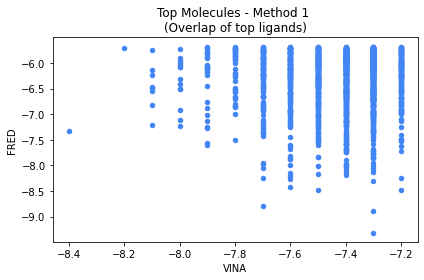

In [16]:
fig = plt.figure(dpi=300, figsize=(15, 15)) 
top_8000_final_top.plot.scatter(x="VINA_score", y="FRED_score", title= "Top overlap Top Ligands", color=color1)
plt.xlabel("VINA")
plt.ylabel("FRED")
plt.title("Top Molecules - Method 1 \n(Overlap of top ligands)")
plt.tight_layout()
# Uncomment if you just want to save this individual plot
plt.savefig('Top_Molecules_Method1.pdf', format='pdf')
plt.show()

#### Step 4.2.2: Method 2 - Normalize scores and sum
Use min-max normalization to get values between 0 and 1 for both scores. Then take the same amount of top molecules as we got from Method 1 (for consistency of number).

In [17]:
normalized_ligands_both_scores = ligands_both_scores.copy()
normalized_ligands_both_scores['VINA_score_normalized'] = (normalized_ligands_both_scores['VINA_score']-normalized_ligands_both_scores['VINA_score'].min())/(normalized_ligands_both_scores['VINA_score'].max()-normalized_ligands_both_scores['VINA_score'].min())
normalized_ligands_both_scores['FRED_score_normalized'] = (normalized_ligands_both_scores['FRED_score']-normalized_ligands_both_scores['FRED_score'].min())/(normalized_ligands_both_scores['FRED_score'].max()-normalized_ligands_both_scores['FRED_score'].min())


normalized_ligands_both_scores['joined_score_normalized'] = normalized_ligands_both_scores['VINA_score_normalized'] + normalized_ligands_both_scores['FRED_score_normalized']
top_normalized_ligands_both_scores  = normalized_ligands_both_scores.sort_values('joined_score_normalized').head(1561)


<Figure size 4500x4500 with 0 Axes>

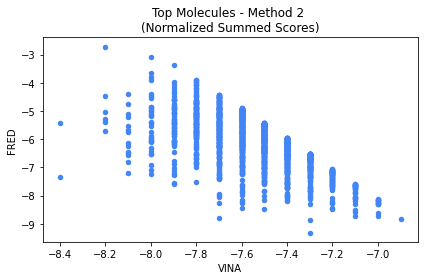

In [18]:
fig = plt.figure(dpi=300, figsize=(15, 15)) 
top_normalized_ligands_both_scores.plot.scatter(x="VINA_score", y="FRED_score",title="Normalized Sum Top Ligands", color=color1)
plt.xlabel("VINA")
plt.ylabel("FRED")
plt.title("Top Molecules - Method 2 \n(Normalized Summed Scores)")
plt.tight_layout()
# Uncomment if you just want to save this individual plot
plt.savefig('Top_Molecules_Method2.pdf', format='pdf')
plt.show()

#### Step 4.2.3: Method 3 - Combined method

Use normalized values and sorting of Method 2 but remove all the molecules that have scores worse than the worst performing molecules of Method 1 for Vina and FRED respectively. Then take the same amount of top molecules as we got from Method 1 (for consistency of number).

In [19]:
filtered_normalized_ligands_both_scores = normalized_ligands_both_scores[normalized_ligands_both_scores['VINA_score'] <= top_8000_final_top['VINA_score'].max()]
filtered_normalized_ligands_both_scores = filtered_normalized_ligands_both_scores[filtered_normalized_ligands_both_scores['FRED_score'] <= top_8000_final_top['FRED_score'].max()]
top_filtered_normalized_ligands_both_scores = filtered_normalized_ligands_both_scores.sort_values('joined_score_normalized').head(1561)

<Figure size 4500x4500 with 0 Axes>

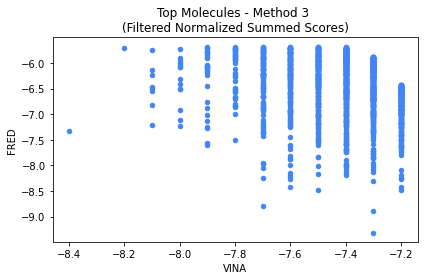

In [20]:

fig = plt.figure(dpi=300, figsize=(15, 15)) 
top_filtered_normalized_ligands_both_scores.plot.scatter(x='VINA_score', y='FRED_score', title="Filtered Normalized Top Ligands",color=color1)
plt.xlabel("VINA")
plt.ylabel("FRED")
plt.title("Top Molecules - Method 3 \n(Filtered Normalized Summed Scores)")
plt.tight_layout()
# Uncomment if you just want to save this individual plot
plt.savefig('Top_Molecules_Method3.pdf', format='pdf')
plt.show()

#### Step 4.2.4: Method 4 - Scaled sum - UPDATE: identical to normalization

In [21]:
scaling_factor = abs(ligands_both_scores['FRED_score'].max() - ligands_both_scores['FRED_score'].min())/abs(ligands_both_scores['VINA_score'].max() - ligands_both_scores['VINA_score'].min())

scaled_sum_ligands_both_scores = ligands_both_scores.copy()
scaled_sum_ligands_both_scores['combined_score'] = scaling_factor*scaled_sum_ligands_both_scores['VINA_score'] + scaled_sum_ligands_both_scores['FRED_score']
top_scaled_sum_ligands_both_scores = scaled_sum_ligands_both_scores.sort_values('combined_score').head(1561)

<Figure size 4500x4500 with 0 Axes>

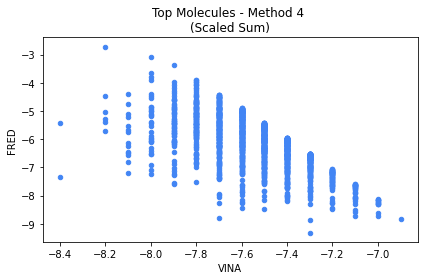

In [22]:

fig = plt.figure(dpi=300, figsize=(15, 15)) 
top_scaled_sum_ligands_both_scores.plot.scatter(x='VINA_score', y='FRED_score', title="Scaled Sum Top Ligands", color=color1)
plt.xlabel("VINA")
plt.ylabel("FRED")
plt.title("Top Molecules - Method 4 \n(Scaled Sum)")
plt.tight_layout()
# Uncomment if you just want to save this individual plot
plt.savefig('Top_Molecules_Method4_Deprecated.pdf', format='pdf')
plt.show()

### Step 4.3: Combine methods and find overlap

Combine the methods and find overlapping molecules that are found in the top results in all methods.

In [23]:
ligands_top_8000_final_top = set(top_8000_final_top['ZINC_ID'])
ligands_top_normalized_ligands_both_scores = set(top_normalized_ligands_both_scores['ZINC_ID'])
ligands_top_scaled_sum_ligands_both_scores = set(top_scaled_sum_ligands_both_scores['ZINC_ID'])
ligands_top_filtered_normalized_ligands_both_scores = set(top_filtered_normalized_ligands_both_scores['ZINC_ID'])

Show the overlap

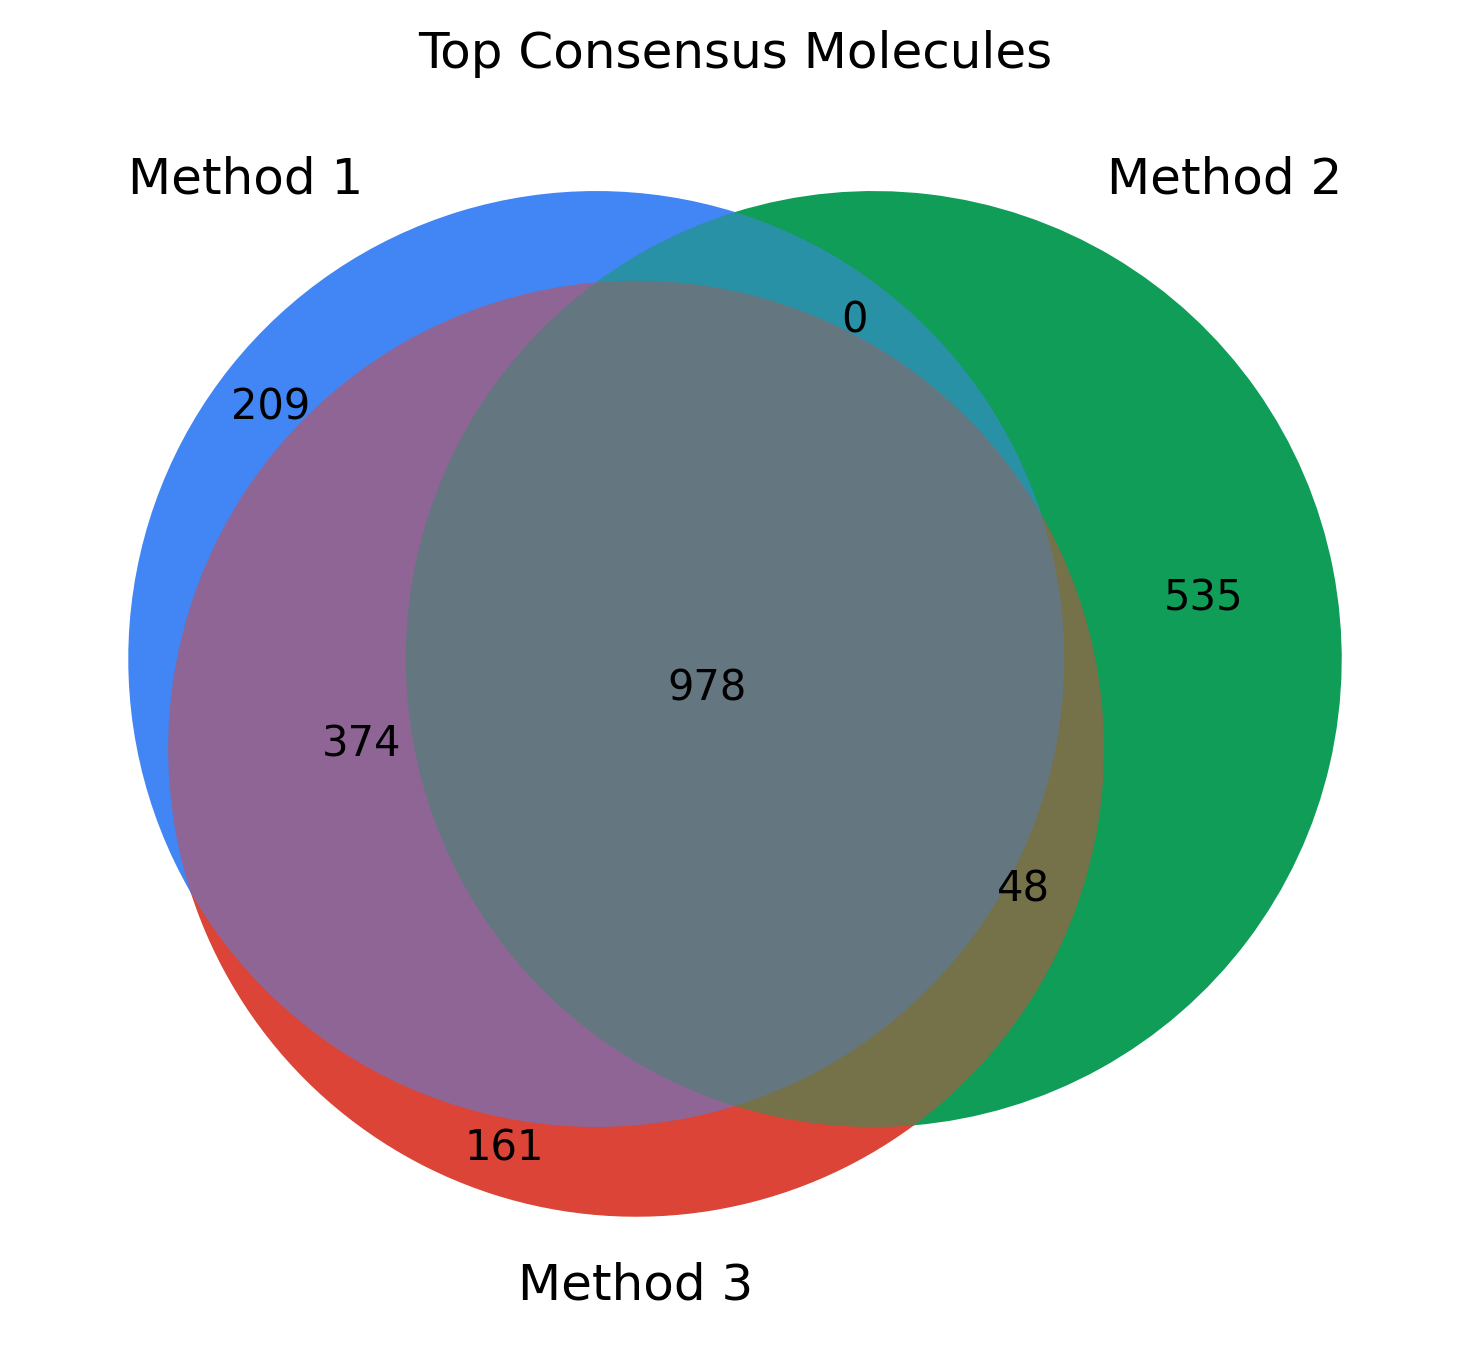

In [24]:
fig = plt.figure(dpi=300, figsize=(5, 5)) 
c = venn3([ligands_top_8000_final_top, ligands_top_normalized_ligands_both_scores, ligands_top_filtered_normalized_ligands_both_scores], ('Method 1', 'Method 2', 'Method 3'))

# Color the sections to match colourtheme
c.get_patch_by_id('100').set_color(color1)
c.get_patch_by_id('100').set_alpha(1)
c.get_patch_by_id('010').set_color(color2)
c.get_patch_by_id('010').set_alpha(1)
c.get_patch_by_id('001').set_color(color4)
c.get_patch_by_id('001').set_alpha(1)
c.get_patch_by_id('101').set_color("#8F6596")
c.get_patch_by_id('101').set_alpha(1)
c.get_patch_by_id('110').set_color("#2991A6")
c.get_patch_by_id('110').set_alpha(1)
c.get_patch_by_id('011').set_color("#757148")
c.get_patch_by_id('011').set_alpha(1)
c.get_patch_by_id('111').set_color("#647781")
c.get_patch_by_id('111').set_alpha(1)
plt.title("Top Consensus Molecules")
plt.tight_layout()
plt.savefig('Top_Consensus_Molecules.pdf', format='pdf')
plt.show()

Get the overlap and save the results

In [25]:
top_consensus = pd.merge(top_8000_final_top, top_normalized_ligands_both_scores, on=['ZINC_ID'])
top_consensus = top_consensus[['ZINC_ID', 'VINA_score_x', 'VINA_filename', 'FRED_score_x', 'FRED_filename']]
top_consensus =top_consensus.rename(columns={'VINA_score_x' : 'VINA_score', 'FRED_score_x': "FRED_score"})

# Uncomment if you want to save
# top_consensus.to_csv("clustering_results/molecule_testing/top_consensus.csv", header=False, index=False)

### Step 4.4: Exploring consensus molecules

In [3]:
top_consensus = pd.read_csv("clustering_results/molecule_testing/top_consensus.csv", names=["ZINC_ID", "VINA_score", "VINA_filename", "FRED_score", "FRED_filename"])

In [6]:
# # Uncomment if you want to see statistics
# print(top_consensus["VINA_score"].min())
# print(top_consensus["VINA_score"].max())
# print(top_consensus["VINA_score"].mean())
# print(top_consensus["VINA_score"].std())
# print(top_consensus["FRED_score"].min())
# print(top_consensus["FRED_score"].max())
# print(top_consensus["FRED_score"].mean())
# print(top_consensus["FRED_score"].std())

In [4]:
top_consensus_fred_filenames = top_consensus[["ZINC_ID", "FRED_filename"]]
top_consensus_fred_filenames = top_consensus_fred_filenames.rename(columns={'ZINC_ID': 'Name'})

## Step 5: Final molecule selection (small number to experimentally test)
**Summary: Make a final molecule selection that will be experimentally tested. Here we are exploring fitness of molecules for central nervous system.**

### Step 5.1 : Method 1 - Strict conditions for BBB penetration - UPDATE: not used

In [31]:
# #suppl = Chem.SDMolSupplier('clustering_results/molecule_testing/top_consensus_fred.sdf')
# # molecules = [x for x in Chem.ForwardSDMolSupplier(open('clustering_results/molecule_testing/top_consensus_fred.sdf')) if x is not None]
# molecules = [x for x in Chem.ForwardSDMolSupplier(open('/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/clustering_results/molecule_testing/top_consensus_fred.sdf','rb')) if x is not None]
# len(molecules)
# output_list = []
# for m in molecules:
#     if(m):
#         logP = Descriptors.MolLogP(m)
#         molWt = Descriptors.MolWt(m)
#         TPSA = Descriptors.TPSA(m)
#         HBD = Chem.rdMolDescriptors.CalcNumHBD(m)
#         if(logP <= 3 and molWt <= 360
#             and TPSA >= 40 and TPSA <= 90
#             and HBD <= 0.5):
#             output_list.append(m.GetProp('_Name'))
# # len(output_list)
# # output_list

In [32]:
# indexes = []
# for index,zinc_id in enumerate(top_consensus["ZINC_ID"]):
#     if zinc_id in output_list:
#         indexes.append(index)

# # print(indexes)

### Step 5.2: Method 2 - Clustering of top consensus - UPDATE: not used, molecules are too different based on the first clustering

First lets prepare put sdf files of top ligands together to one file.

In [33]:
#!awk -F',' '{print $NF}' top_consensus.csv > top_consensus_fred_filenames.txt
#!while read p; do cat $p >> top_consensus_fred.sdf; done <top_consensus_fred_filenames.txt

Now let's perform the clustering

In [34]:
#!conda activate DD_protocol_py27
#! rdkit2fps top_consensus_fred.sdf --fpSize 1024 --morgan --radius 2 --useChirality 1 > top_consensus_fred.fps
#! sbatch--account={account_name} --partition={cpu_partition} --nodes=1 --ntasks=1 --cpus-per-task=10 --time=02:00:00 --wrap="python /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/scripts_3/taylor_butina.py --profile --threshold 0.78 top_consensus_fred_check.fps -o top_consensus_fred_check_clusters.txt"


### Step 5.3: Method 3 - Using DeePred-BBB and Gaucamol MPO scoring

#### Step 5.3.1: Get smiles from (FRED) SDF files.

These are the molecules and poses we have the scores for.

In [35]:
# !python ../scripts_3/sdftosmile.py -file clustering_results/molecule_testing/top_consensus_fred.sdf -path_to_store clustering_results/molecule_testing 

#!cp clustering_results/molecule_testing/top_consensus_fred.smi /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/smiles.smi

#### Step 5.3.2: Use DeePred-BBB (https://github.com/12rajnish/DeePred-BBB) to get permeability prediction.

(Not used) but for altered code to display scores rounded to 2 decimal places instead of 0 vs 1, perform this change, change line 19 and 20 in DeePred-BBB_Script.py as below. However, it might be better to just take the scores as binary.

In [36]:
#prediction = loaded_model.predict(bbb_user_input).round(2)
#prediction = prediction[:,0].astype(float)

##### Step 5.3.2.1: Process results (prediction.csv and feature.csv)


In [5]:
# Uncomment if you want to regenerate data
# predbbb_feature = pd.read_csv("/rds/user/mb2462/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/past_results/logine_feature.csv")
# predbbb_prediction = pd.read_csv("/rds/user/mb2462/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/past_results/logine_prediction.csv", header=None, names=["Predicted"])
# predbbb_merged = pd.merge(predbbb_feature, predbbb_prediction, left_index=True, right_index=True)
# predbbb_merged.to_csv("clustering_results/molecule_testing/top_consensus_permeability_tensor.csv")

predbbb = pd.read_csv("clustering_results/molecule_testing/top_consensus_permeability_tensor.csv")
predbbb = predbbb.sort_values(by=['Predicted'],ascending=False)
# # predbbb.to_csv("clustering_results/molecule_testing/top_consensus_deeppredbbb_sorted.csv")

#### Step 5.3.3: Get CNS_MPO Guacamol scores

Calculate Guacamole score. Also calculate accompanying values for chemical properties (this is used for having a more comprehensive table for each molecule later).

In [6]:
molecules = [x for x in Chem.ForwardSDMolSupplier(open('/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering_and_downstream_analysis/clustering_results/molecule_testing/top_consensus_fred.sdf','rb')) if x is not None]
mpo_scores = []
mpo_names = []
mpo_mw = []
mpo_lp = []
mpo_hbd = []
mpo_mol_tpsa = []
CNS = CNS_MPO_ScoringFunction()
for mol in molecules:
    score = CNS.score_mol(mol)
    mpo_scores.append(score)
    mpo_names.append(mol.GetProp('_Name'))
    mpo_mw.append(mol_weight(mol))
    mpo_lp.append(logP(mol))
    mpo_hbd.append(num_H_donors(mol))
    mpo_mol_tpsa.append(tpsa(mol))

Create table with values

In [7]:
mpo_dict = {'Name' : mpo_names, 
            'Mol_Weight': mpo_mw, 
            'LogP' : mpo_lp, 
            'Num_H_donors' : mpo_hbd, 
            "TPSA" : mpo_mol_tpsa,
            'MPO_score':mpo_scores}
mpo= pd.DataFrame(mpo_dict)
mpo= mpo.sort_values(by="MPO_score", ascending=False)

# Uncomment if want to save
# mpo.to_csv("clustering_results/molecule_testing/top_consensus_mpo.csv", index=False)


#### Step 5.3.4: Merge all the results 

Merge MPO scores and DeePred-BBB scores as well as Vina and FRED scores and store it.

In [8]:
# Matplotlib font changes for plotting 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [9]:
# Uncomment if you want to update the data again 
# merged_mpo_predbbb = pd.merge(mpo, predbbb, on="Name")
# merged_mpo_predbbb_vina_fred_scores  =  pd.merge(merged_mpo_predbbb, top_consensus, on="Name")
# clean_merged_mpo_predbbb_vina_fred_scores = merged_mpo_predbbb_vina_fred_scores[["Name", 'Mol_Weight', 'LogP', "Num_H_donors", "TPSA", "MPO_score", "Predicted", "VINA_score", "FRED_score"]]
# clean_merged_mpo_predbbb_vina_fred_scores = clean_merged_mpo_predbbb_vina_fred_scores.rename(columns={'Predicted': 'DeePred-BBB Prediction'}) 
# clean_merged_mpo_predbbb_vina_fred_scores.to_csv("clustering_results/molecule_testing/top_consensus_all_scores.csv")

clean_merged_mpo_predbbb_vina_fred_scores = pd.read_csv("clustering_results/molecule_testing/top_consensus_all_scores.csv")
# Remove the first column containing the indexes
clean_merged_mpo_predbbb_vina_fred_scores = clean_merged_mpo_predbbb_vina_fred_scores.iloc[:, 1:]

Display MPO, VINA and FRED score in one plot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


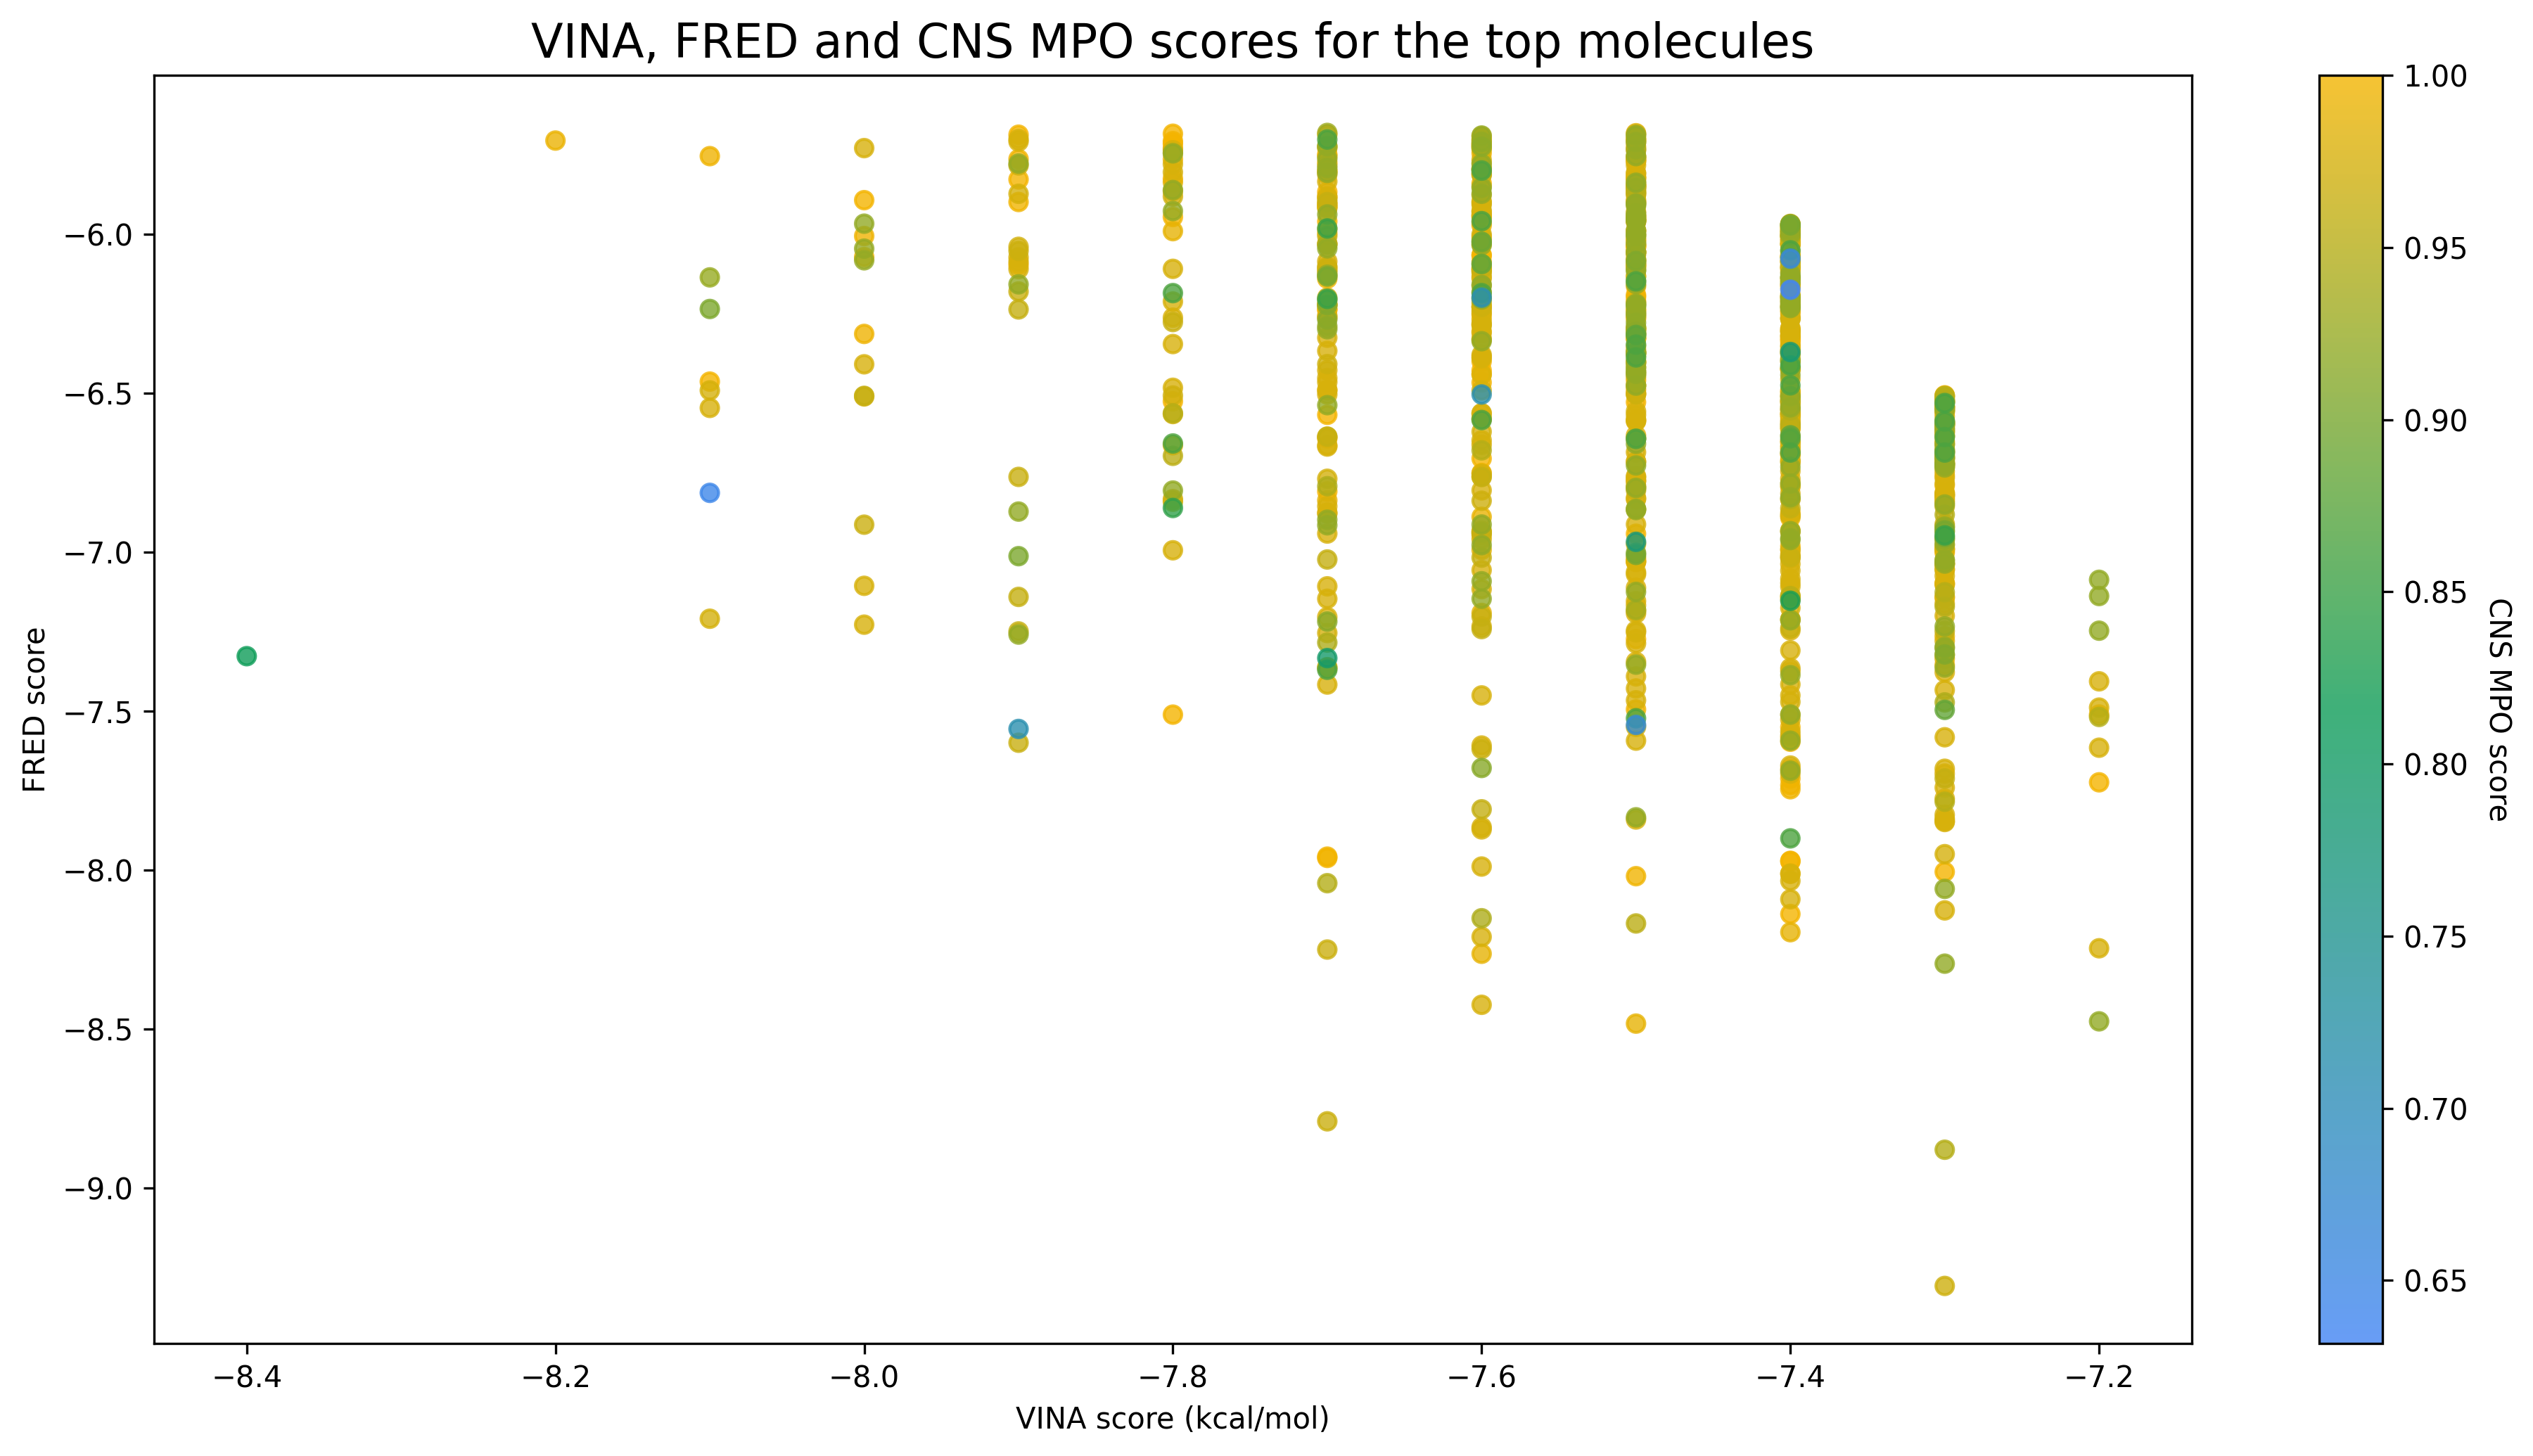

In [ ]:
# Uncomment if you want to save plots to 1 pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("top_consensus_all_scores_graphs.pdf")
fig = plt.figure(dpi=300, figsize=(13, 7)) 
plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores['FRED_score'],
            c= clean_merged_mpo_predbbb_vina_fred_scores['MPO_score'],  cmap=custom_cmap, alpha=0.8)


cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('CNS MPO score', rotation=270)
plt.xlabel('VINA score (kcal/mol)')
plt.ylabel('FRED score')
plt.title('VINA, FRED and CNS MPO scores for the top molecules', fontsize=16)
# Uncomment if you want to save plots to 1 pdf
# pdf.savefig(fig)
plt.tight_layout()
plt.savefig('vina_fred_cns_mpo_scores_consensus_molecules.pdf', format='pdf')
plt.show()


Display VINA, FRED scores and DeePred-BBB passing prediction in one plot.

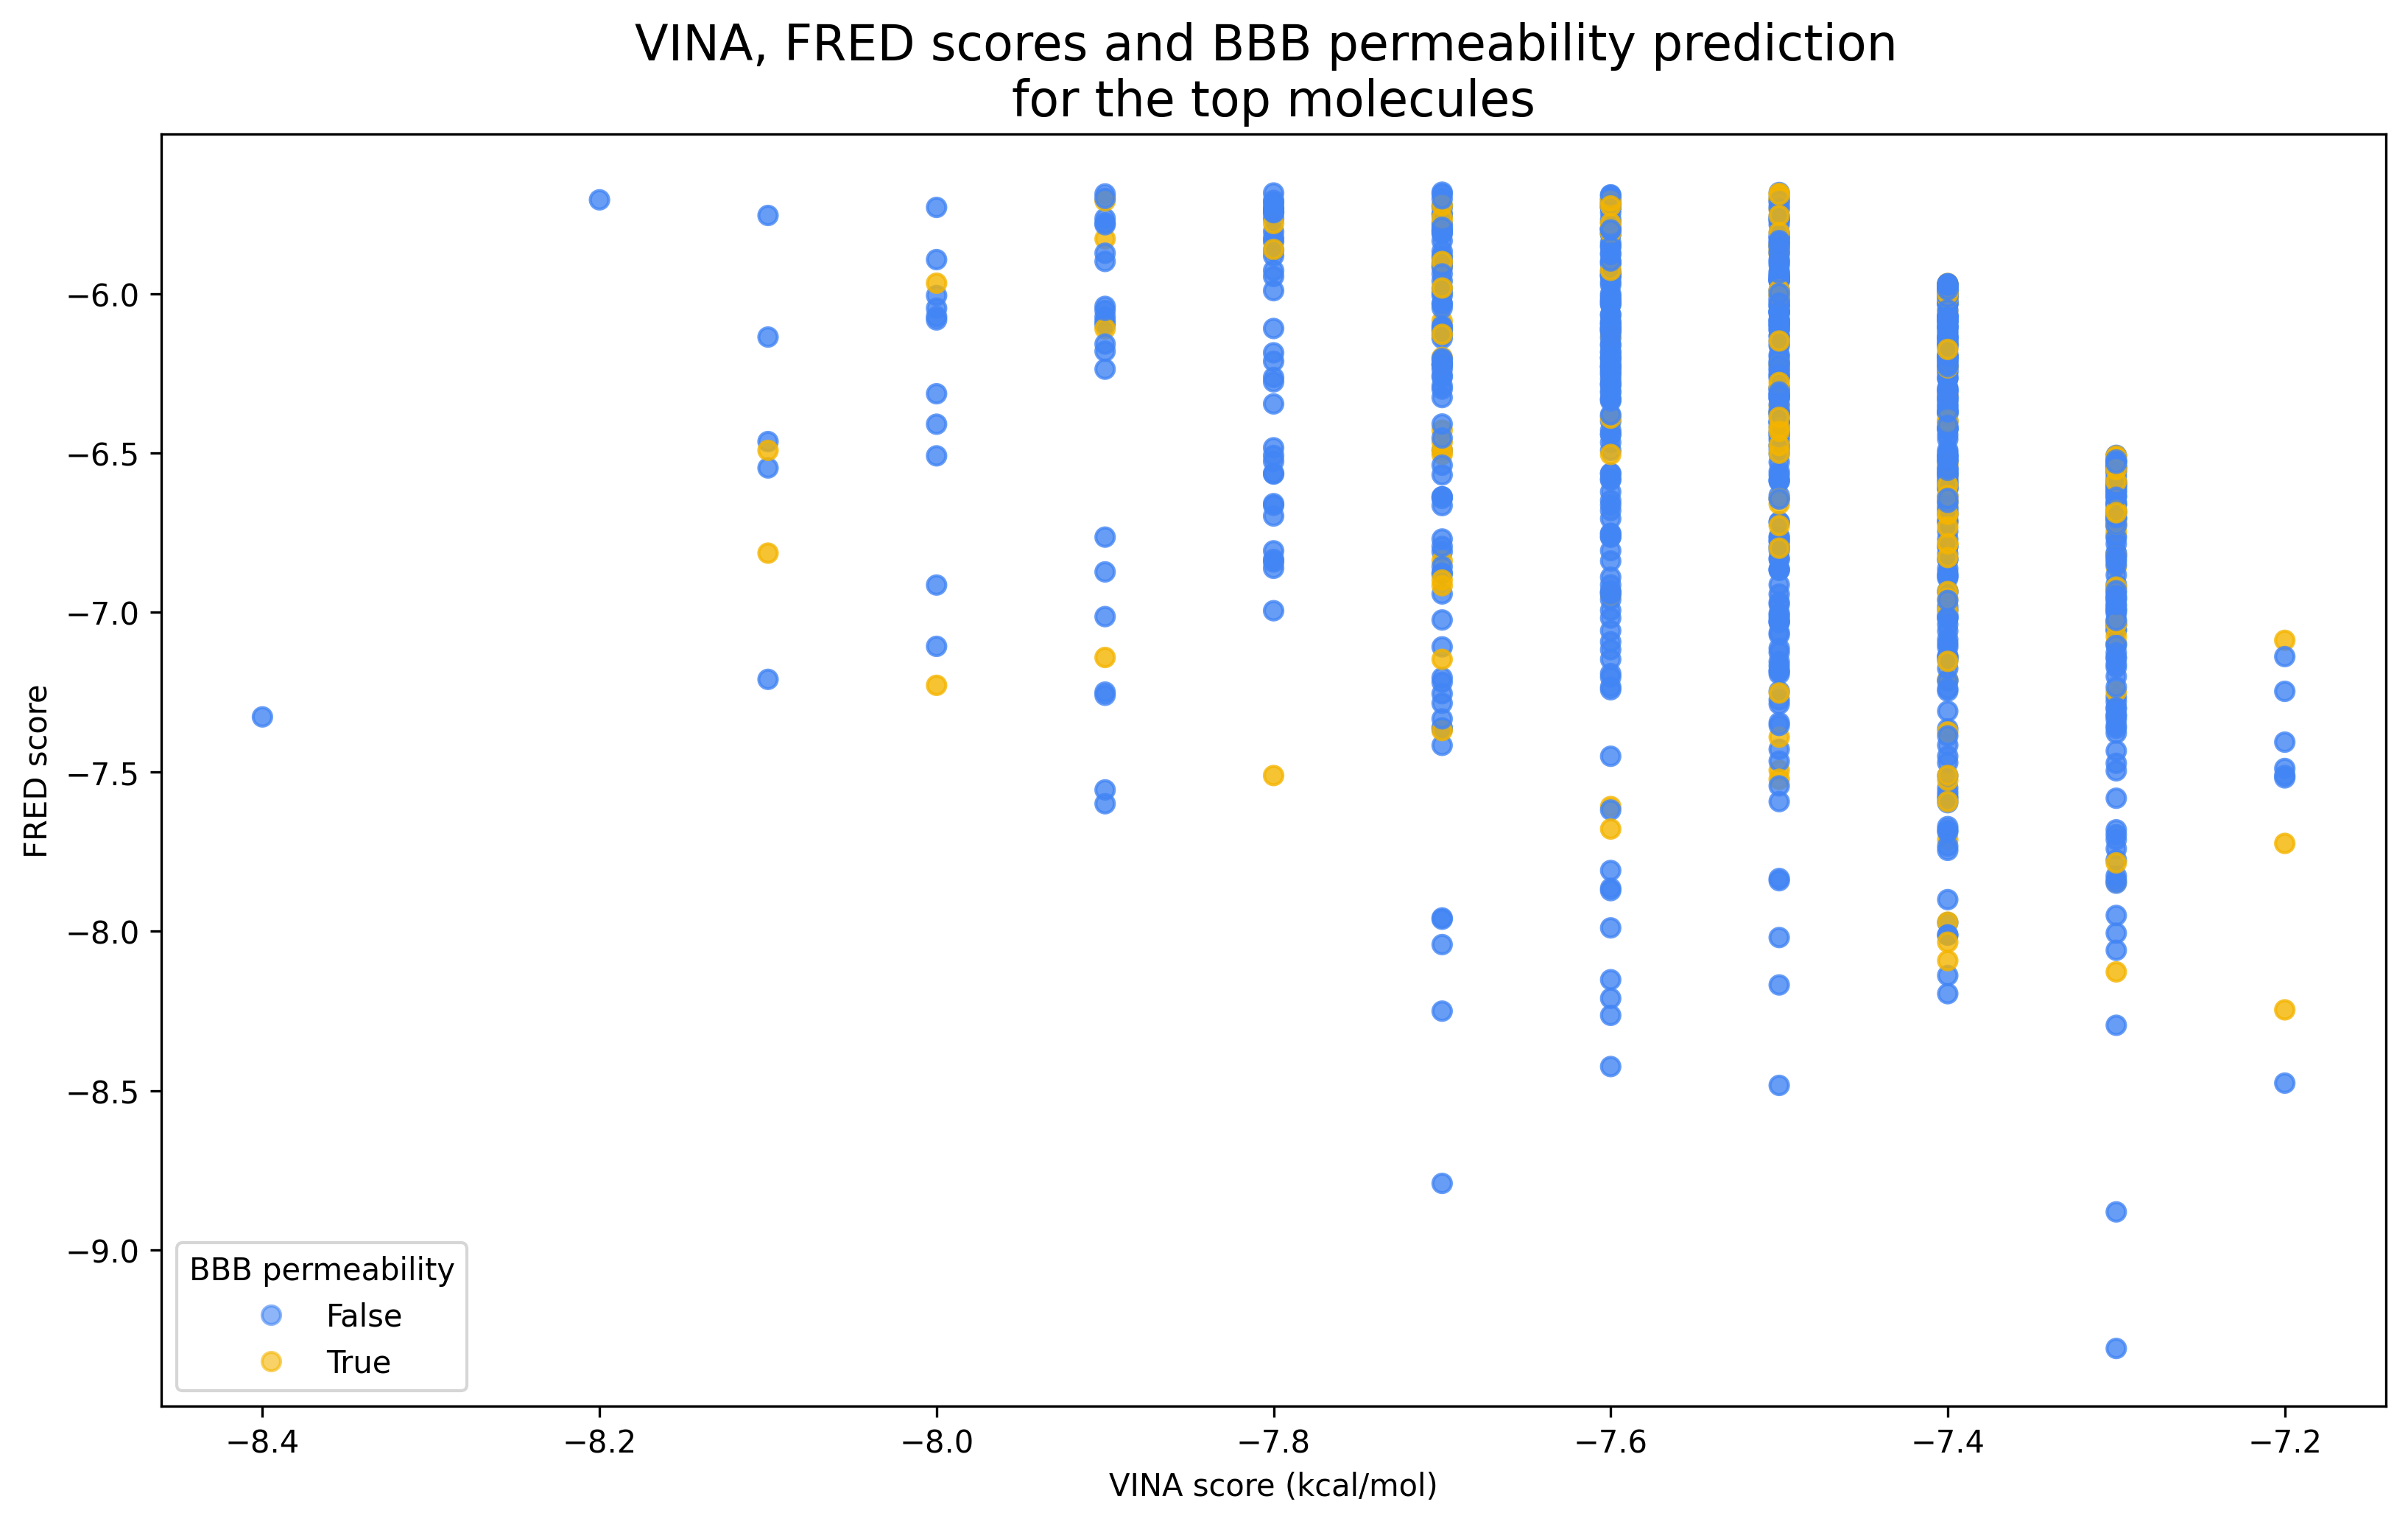

In [10]:
fig = plt.figure(dpi=300, figsize=(11, 7)) 


clean_merged_mpo_predbbb_vina_fred_scores = clean_merged_mpo_predbbb_vina_fred_scores[clean_merged_mpo_predbbb_vina_fred_scores['DeePred-BBB Prediction']>-1]
scatter = plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores['DeePred-BBB Prediction'],  cmap=custom_cmap,  alpha=0.8)

# Create a legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend_labels = ["False", "True"]

# cbar = plt.colorbar(ticks=np.linspace(0,1,2))
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('DeePred-BBB Prediction', rotation=270)
plt.xlabel('VINA score (kcal/mol)')
plt.ylabel('FRED score')
plt.title('VINA, FRED scores and BBB permeability prediction \nfor the top molecules', fontsize=16)
# Uncomment if you want to save plots to 1 pdf
# pdf.savefig(fig)
legend = plt.legend(handles, legend_labels, title="BBB permeability", loc="lower left")


# Adjust the location of the legend to ensure it displays correctly
plt.tight_layout()
# plt.savefig('vina_fred_bbb_permeability_consensus_molecules.pdf', format='pdf')
plt.show()

### Step 5.4: Final selection

####  Step 5.4.1: Final selectionGet all data passing DeePred-BBB (=1) and having MPO score > 0.9

In [11]:
clean_merged_mpo_predbbb_vina_fred_scores_passing = clean_merged_mpo_predbbb_vina_fred_scores[clean_merged_mpo_predbbb_vina_fred_scores['DeePred-BBB Prediction']==1]
clean_merged_mpo_predbbb_vina_fred_scores_passing = clean_merged_mpo_predbbb_vina_fred_scores_passing[clean_merged_mpo_predbbb_vina_fred_scores_passing['MPO_score']>0.9]

Show Vina FRED and MPO score for the passing molecules.

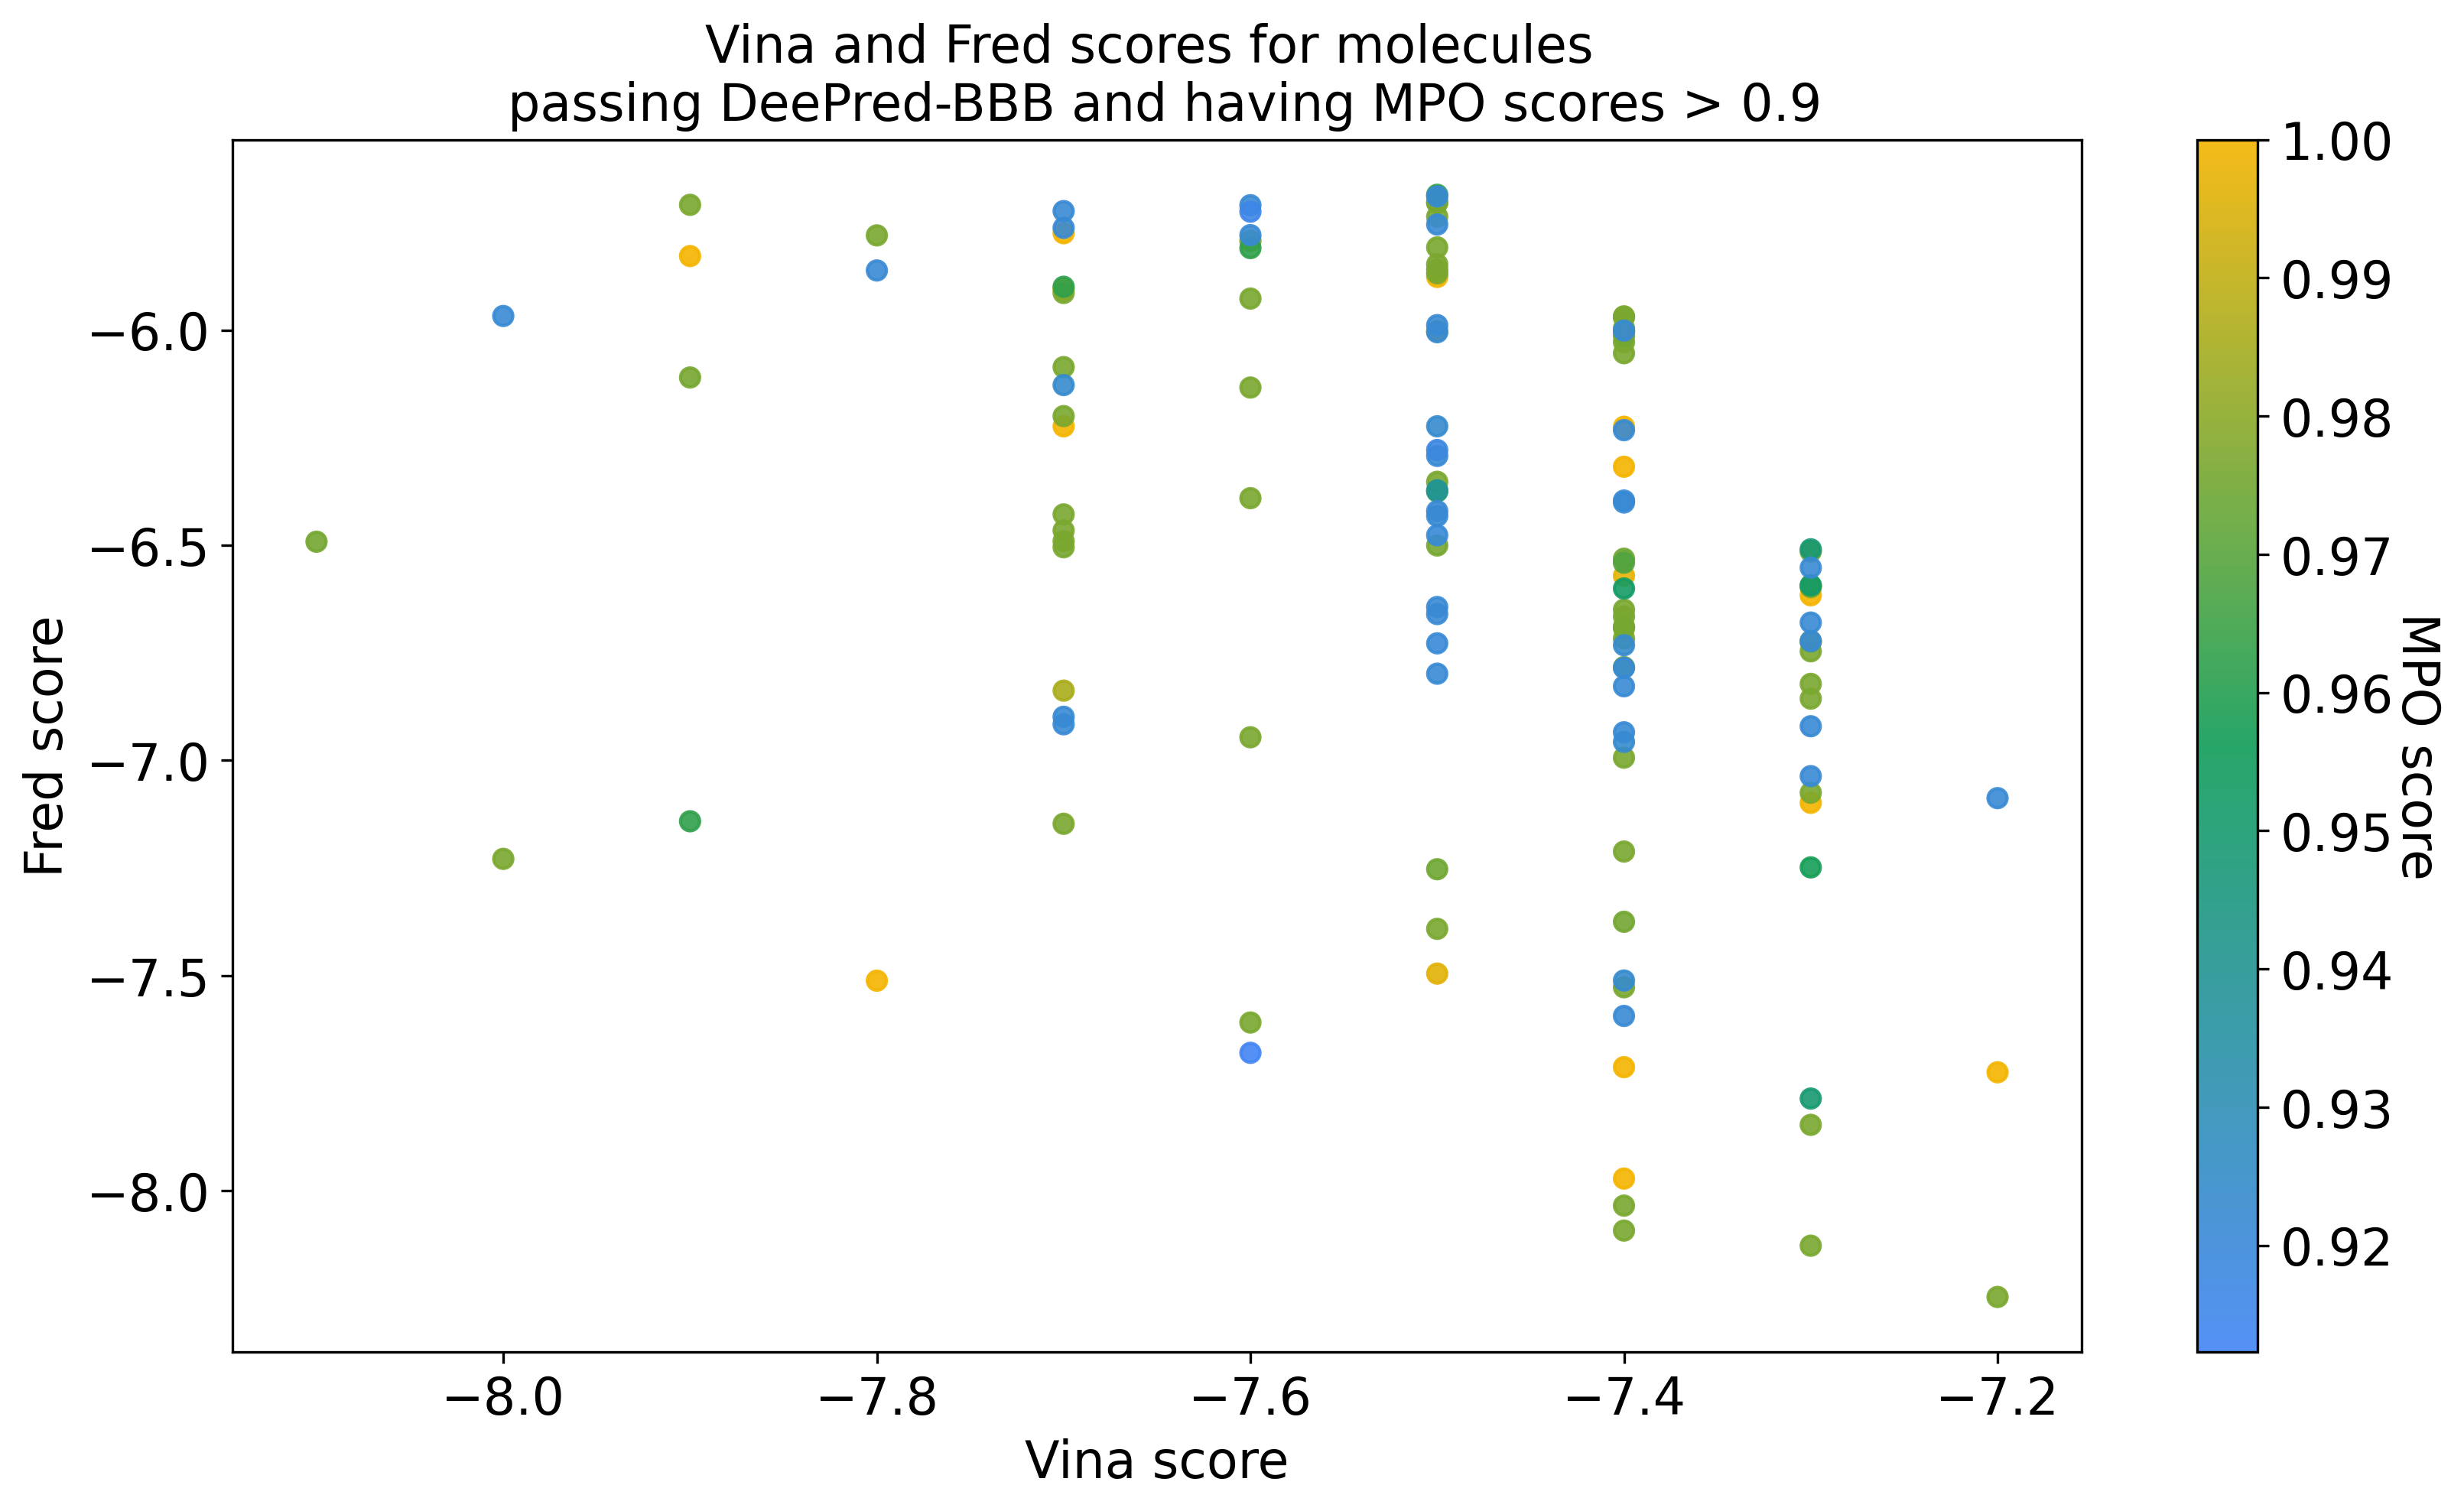

In [19]:
fig = plt.figure(dpi=300, figsize=(13, 7)) 

# Create an axis within the figure
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
# plt.grid(axis='y', alpha=0.75, zorder=-1)
plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing['MPO_score'],  cmap=custom_cmap,  alpha=0.9)

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('MPO score', rotation=270)
plt.xlabel('Vina score')
plt.ylabel('Fred score')
plt.title('Vina and Fred scores for molecules \n passing DeePred-BBB and having MPO scores > 0.9', fontsize=16)

# # Uncomment if you just want to save this specific plot
# plt.tight_layout()
# # plt.grid(axis='y', alpha=0.75)
# plt.savefig('Vina_Fred_scores_molecules_passing_DeePred-BBB_MPOscore_over_09.pdf', format='pdf')

# Uncomment if you want to save plots to 1 pdf
# pdf.savefig(fig)
# pdf.close()
plt.show()


#### Step 5.4.2: For passing data, get stricter selection based on the Vina and FRED scores

Stricter selection is performed **only to reduce number of molecules to experimentally test**. We are using plot-based thresholding to preferentially select molecules with better Vina and FRED scores (molecules under a linear function).

In [12]:
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold = clean_merged_mpo_predbbb_vina_fred_scores_passing.copy(deep=True)
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['FRED_threshold_for_Vina'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['VINA_score'].apply(lambda x: -2.75*x-139/5 )
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['threshold_pass'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold.apply(lambda x: 1 if x['FRED_score'] <= x['FRED_threshold_for_Vina'] else 0, axis=1)

Display data passing the stricter selection based on Vina and FRED scores. Passing molecules are under the diagonal

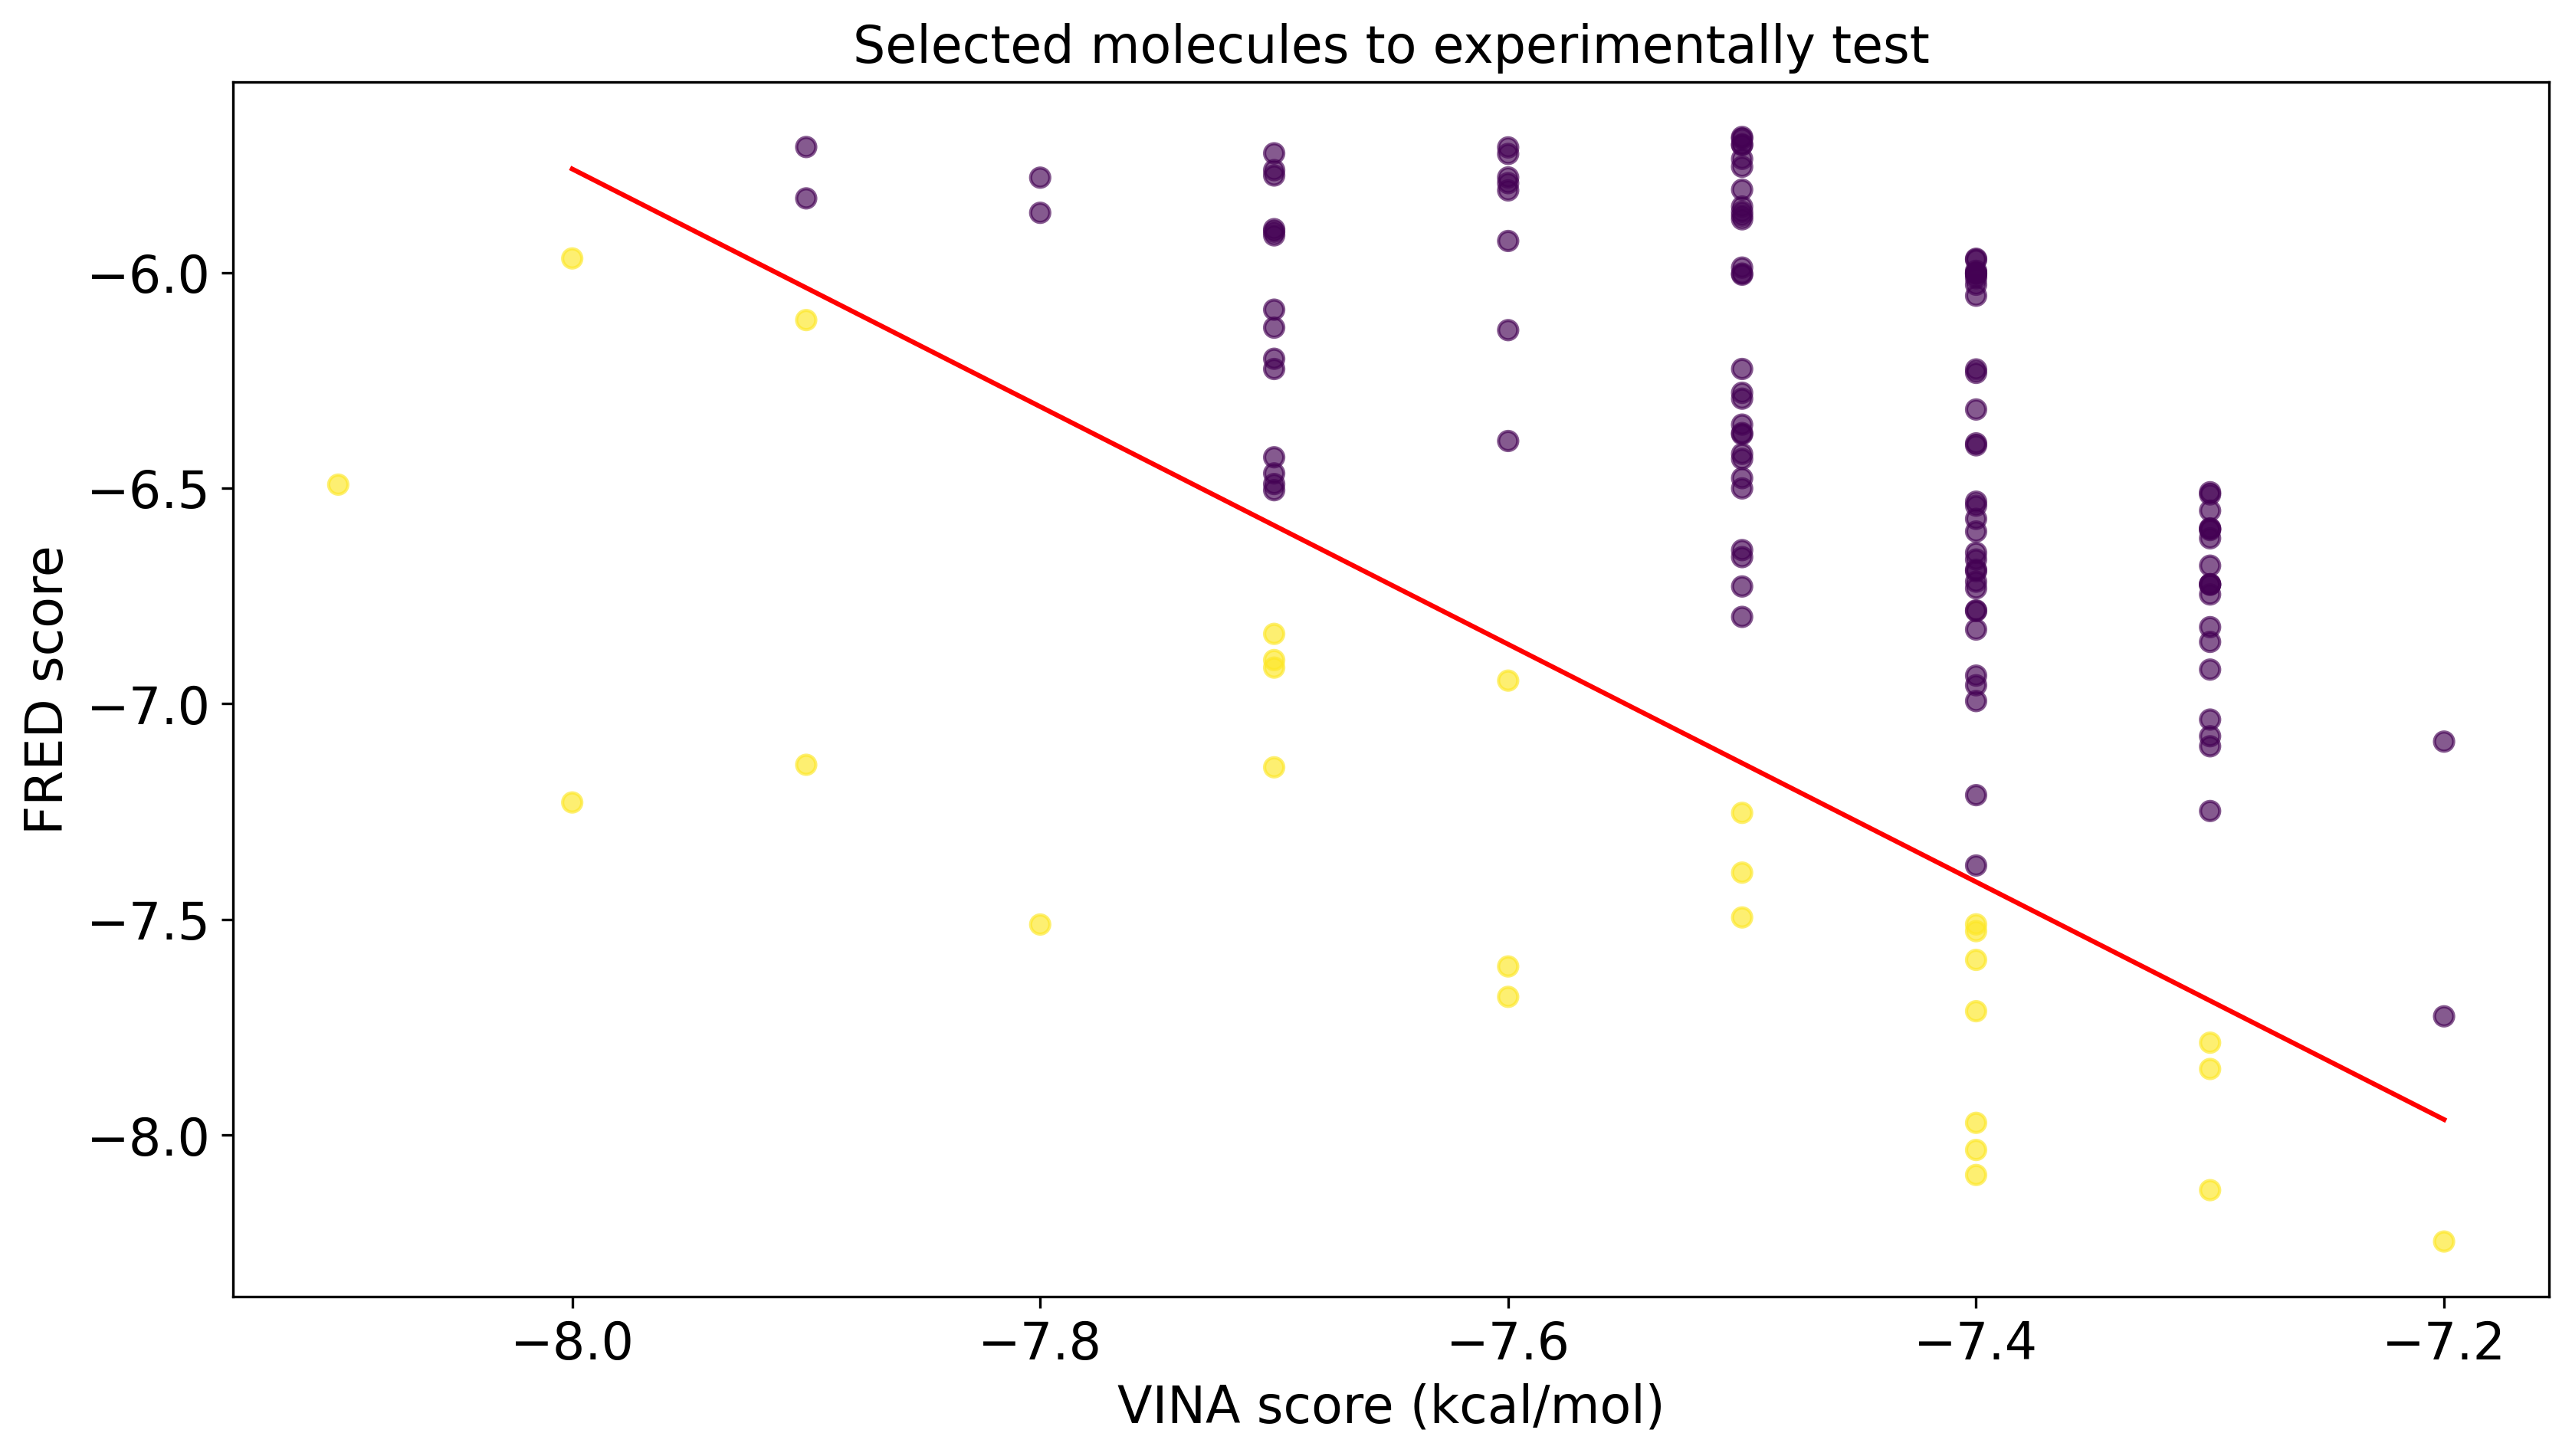

In [21]:
# Uncomment if you want to save plot using Pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("selection_based_on_diagonal.pdf")
fig = plt.figure(dpi=300, figsize=(13, 7)) 

plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['threshold_pass'],  cmap='viridis',  alpha=0.65)

x_diagonal = np.linspace(-8, -7.2, 100)
y_diagonal = -2.755*x_diagonal-139/5 
plt.plot(x_diagonal, y_diagonal, c="red")
plt.xlabel('VINA score (kcal/mol)')
plt.ylabel('FRED score')
plt.title('Selected molecules to experimentally test', fontsize=16)
# Uncomment if you want to save plot using Pdf
# pdf.savefig(fig)
plt.show()
# Uncomment if you want to save plot using Pdf
# pdf.close()

Save the passing data.

In [13]:
selected_clean_merged_mpo_predbbb_vina_fred_scores_passing =  clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold[clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['threshold_pass']==1]
# Uncomment if you want to save it again
# selected_clean_merged_mpo_predbbb_vina_fred_scores_passing.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test.csv', index=False)

In [ ]:
selected_top_consensus_fred_filenames_only = pd.merge(selected_clean_merged_mpo_predbbb_vina_fred_scores_passing, top_consensus_fred_filenames, on="Name")[["FRED_filename"]]
# Uncomment if you want to save it again
# selected_top_consensus_fred_filenames_only.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_fred_filenames.csv',  index=False, header=False)

#### Step 5.4.3: For passing data, get scricter selection based on the Vina and FRED scores (less strict alternative)

Get less stringent list of molecules to test. This is just relaxed version of previous plot-based thresholding (molecules under a linear function). **This is used only to reduce number of molecules to experimentally test**.

In [24]:
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold = clean_merged_mpo_predbbb_vina_fred_scores_passing.copy(deep=True)
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['FRED_threshold_for_Vina'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['VINA_score'].apply(lambda x: -2.75*x-135.5/5 )
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold.apply(lambda x: 1 if x['FRED_score'] <= x['FRED_threshold_for_Vina'] else 0, axis=1)

Show molecules passing the less strict selection based on Vina and Fred scores. Molecules are under the line

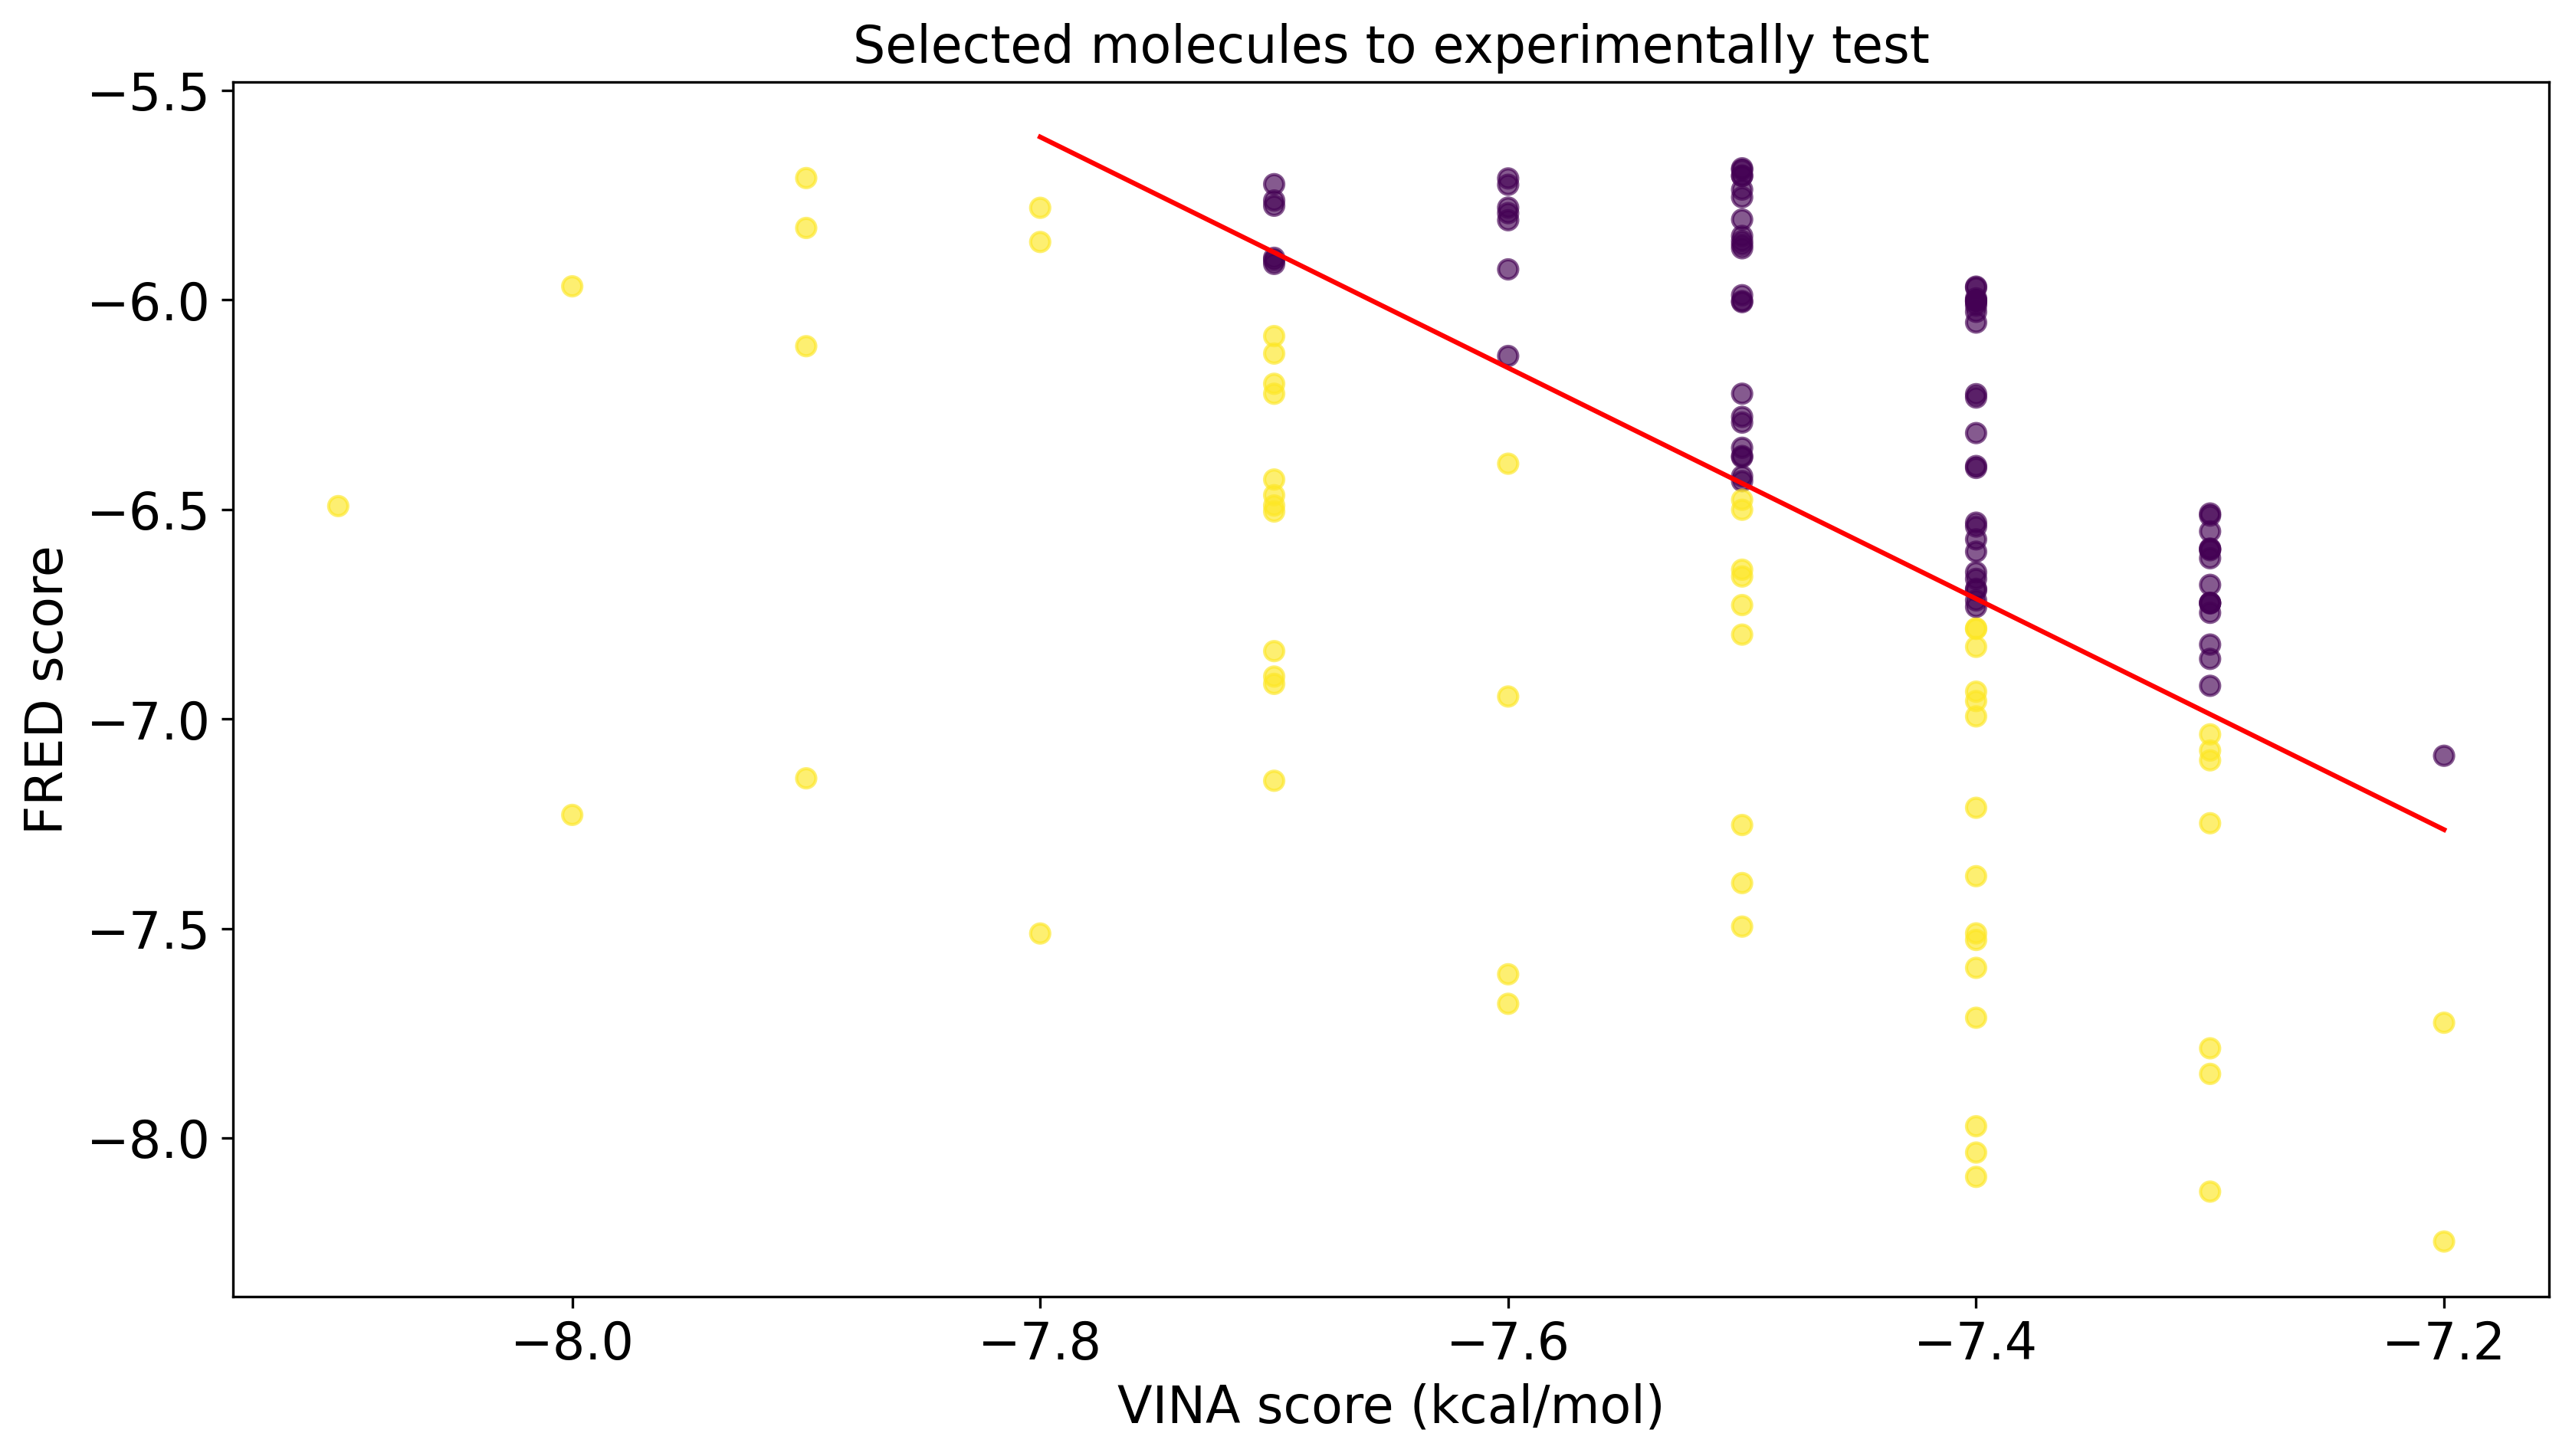

In [25]:
# Uncomment if you want to save plot using Pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("selection_based_on_diagonal_less_strict.pdf")
fig = plt.figure(dpi=300, figsize=(13, 7)) 

plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass'],  cmap='viridis',  alpha=0.65)

x_diagonal = np.linspace(-7.8, -7.2, 100)
y_diagonal = -2.755*x_diagonal-135.5/5
plt.plot(x_diagonal, y_diagonal, c="red")
plt.xlabel('VINA score (kcal/mol)')
plt.ylabel('FRED score')
plt.title('Selected molecules to experimentally test', fontsize=16)
# Uncomment if you want to save plot using Pdf
# pdf.savefig(fig)
plt.show()
# Uncomment if you want to save plot using Pdf
# pdf.close()

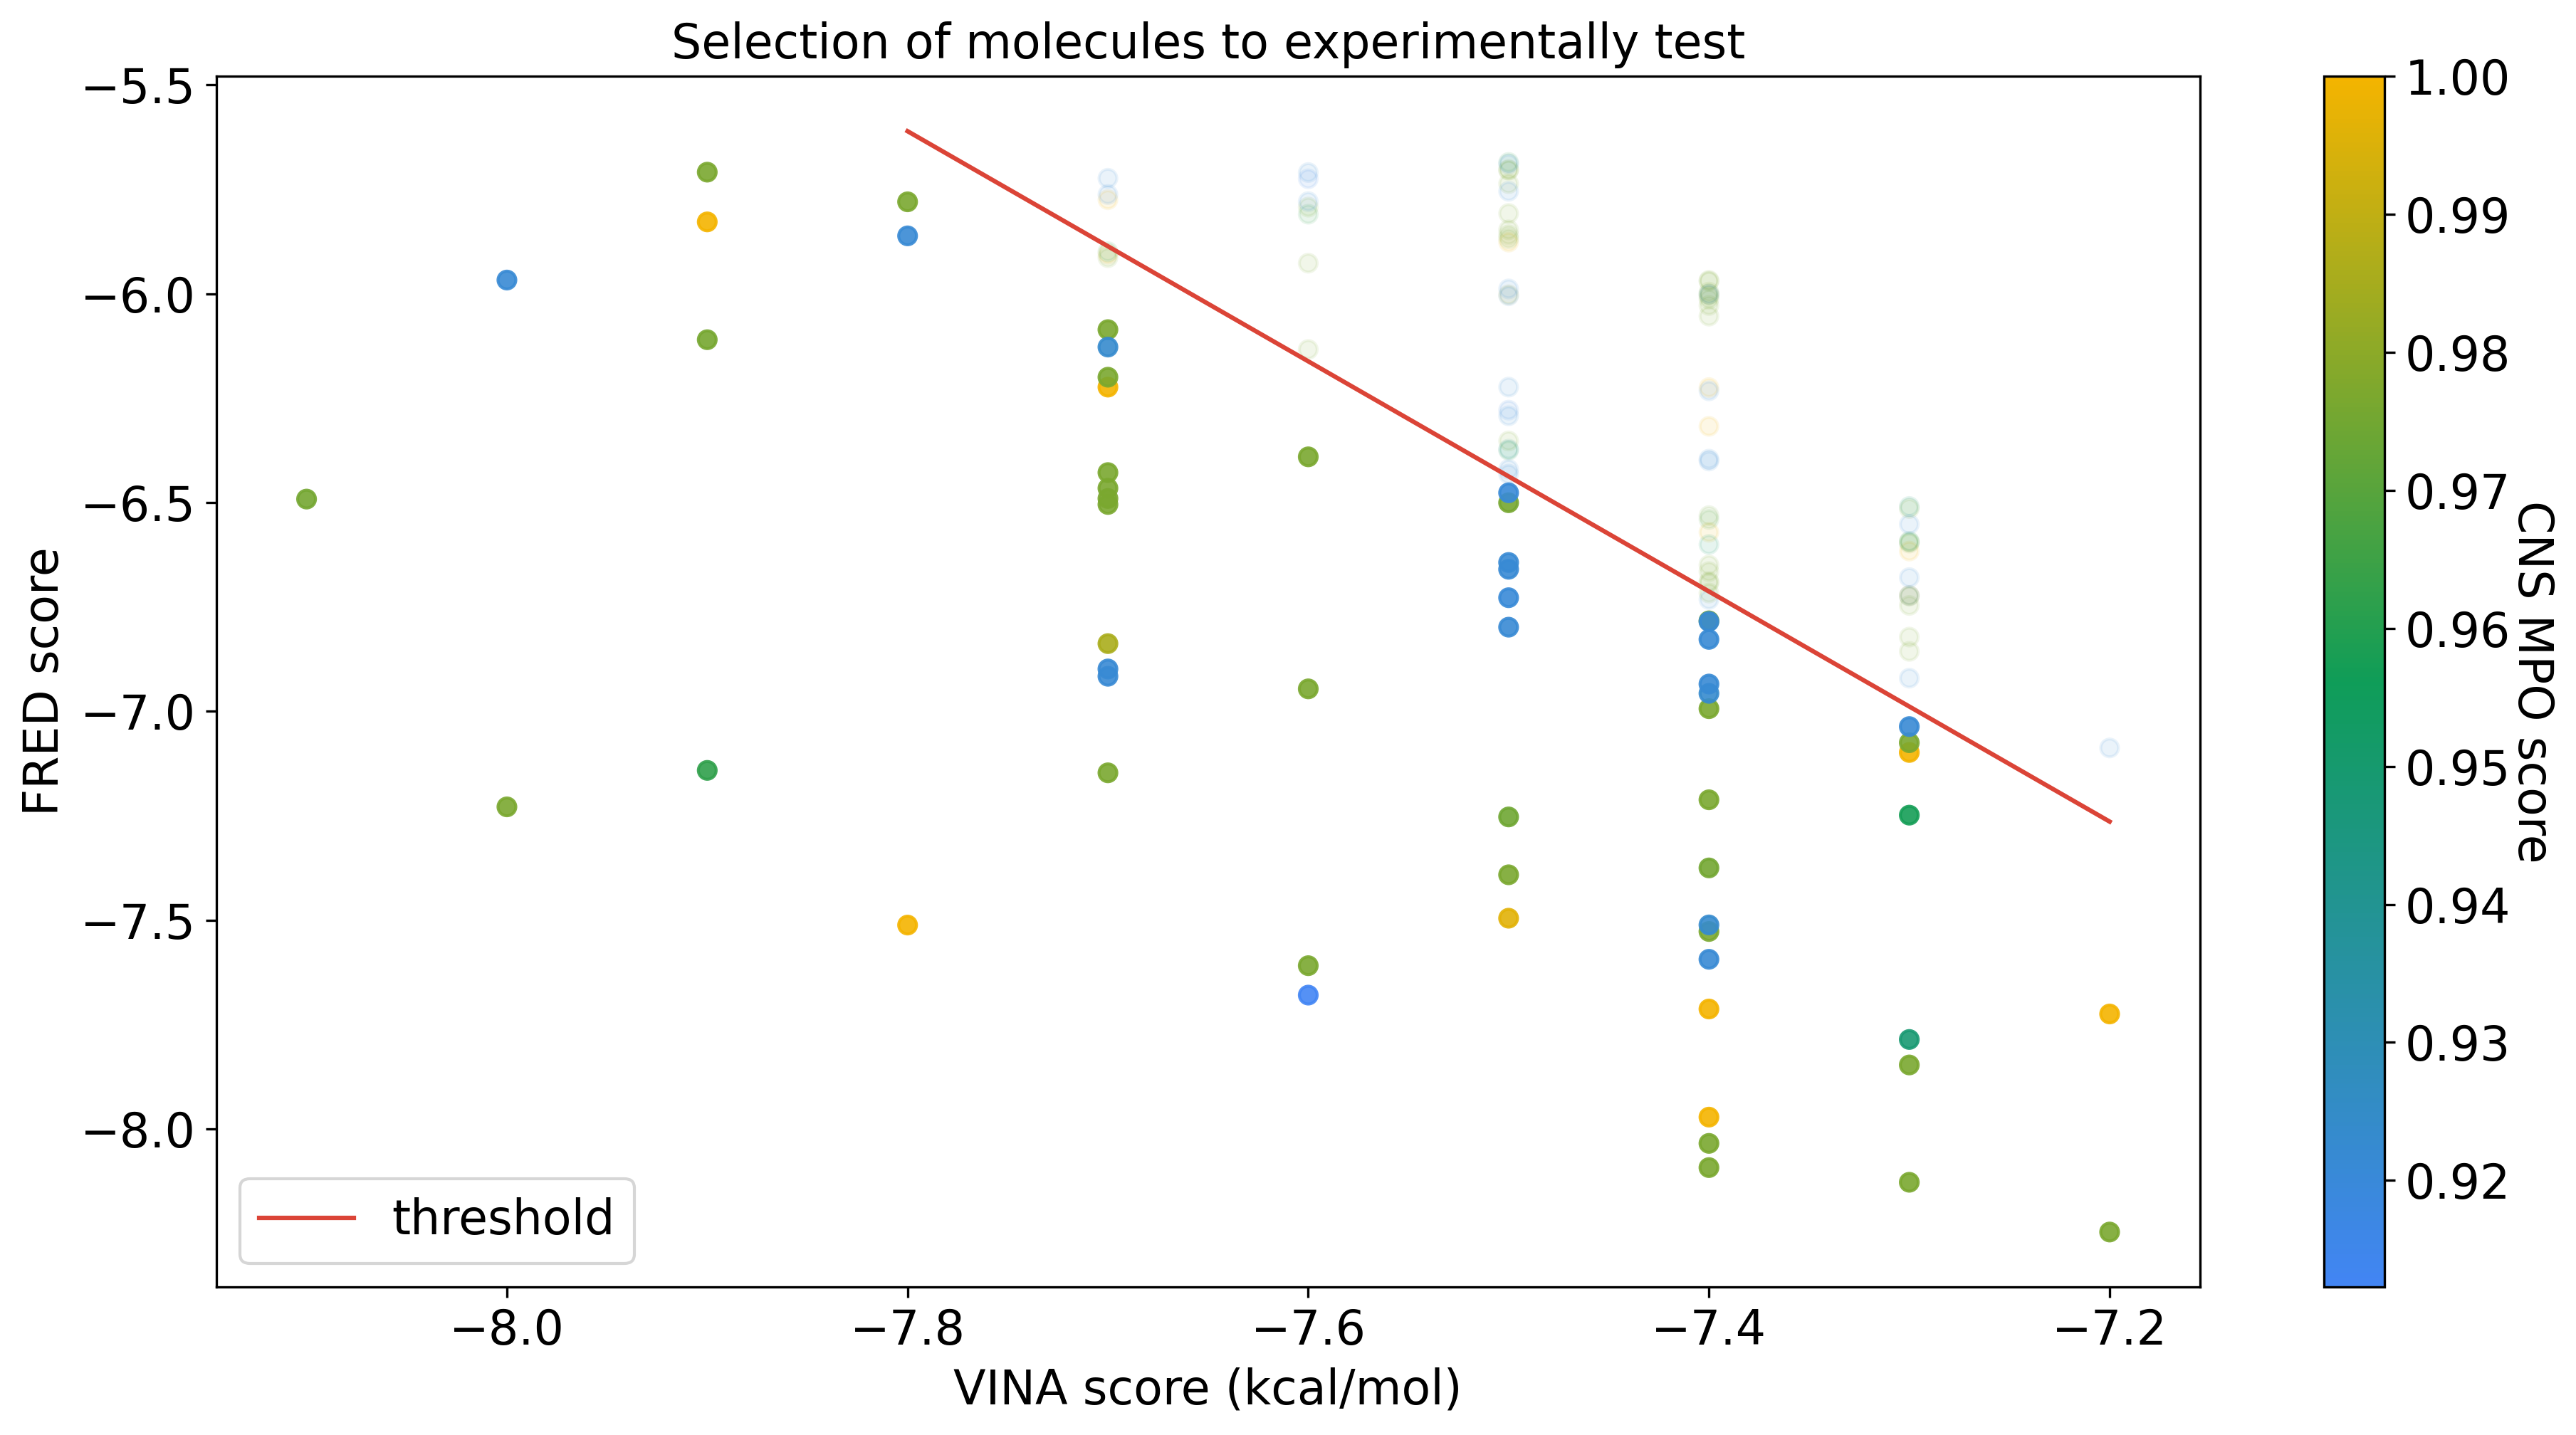

In [27]:
# Uncomment if you want to save plot using Pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("selection_based_on_diagonal_less_strict.pdf")
fig = plt.figure(dpi=300, figsize=(13, 7)) 

# Create an axis within the figure
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
# plt.grid(axis='y', alpha=0.75, zorder=-1)

alpha_mapping =  {1: 0.9, 0: 0.1}
plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['MPO_score'],   cmap=custom_cmap,  alpha=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass'].map(alpha_mapping))

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('CNS MPO score', rotation=270)

x_diagonal = np.linspace(-7.8, -7.2, 100)
y_diagonal = -2.755*x_diagonal-135.5/5
plt.plot(x_diagonal, y_diagonal, c="#db4437", label="threshold")
plt.xlabel('VINA score (kcal/mol)')
plt.ylabel('FRED score')
plt.title('Selection of molecules to experimentally test', fontsize=16)
plt.legend(loc="lower left")

# # Uncomment if you want to save plot using Pdf
# pdf.savefig(fig)
plt.tight_layout()
# Uncomment if you just want to save this individual plot
plt.savefig('Vina_Fred_scores_molecules_selected_passing_DeePredBBB_and_CNS_MPO_score.pdf', format='pdf')
plt.show()

# Uncomment if you want to save plot using Pdf
# pdf.close()

Save the less strictly selected molecules

In [54]:
selected_looser_threshold_clean_merged_mpo_predbbb_vina_fred_scores_passing =  clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold[clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass']==1]
# Uncomment if you want to save
# selected_looser_threshold_clean_merged_mpo_predbbb_vina_fred_scores_passing.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict.csv', index=False)

In [55]:
selected_looser_threshold_top_consensus_fred_filenames_only = pd.merge(selected_looser_threshold_clean_merged_mpo_predbbb_vina_fred_scores_passing, top_consensus_fred_filenames, on="Name")[["FRED_filename"]]
# Uncomment if you want to save
# selected_looser_threshold_top_consensus_fred_filenames_only.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict_fred_filenames.csv',  index=False, header=False)

#### Step 5.5: Get SDFs of selected top molecules (for both levels of strictness)

In [91]:
#!while read p; do cat "$p" >> clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test.sdf ; done<clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_fred_filenames.csv
#!while read p; do cat "$p" >> clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict.sdf ; done<clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict_fred_filenames.csv

In [32]:
# Change filenames if doing less strict molecules set
# molecules = [x for x in Chem.ForwardSDMolSupplier(open('/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/clustering_results/molecule_testing/top_consensus_fred.sdf','rb')) if x is not None]
# # mol.GetProp('_Name')
# with Chem.SDWriter('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test.sdf') as w:
#     for m in molecules:
#         print(m.GetProp('_Name'))
#         if selected_clean_merged_mpo_predbbb_vina_fred_scores_passing['Name'].str.contains(m.GetProp('_Name')).any():
#             w.write(m)

## Useful (bash commands)

1. Get line(s) that contain the given string (in this case "singletons") 

In [41]:
# grep -hnr "singletons" extracted_smiles_clusters_1024_full.txt